按顺序运行

In [33]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')
# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [22]:
# Cell 1: 环境设置与导入
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import sys
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🎯 使用设备: {device}")
print(f"PyTorch版本: {torch.__version__}")

# 检查CUDA可用性
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🎮 GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ 未检测到GPU，将使用CPU训练（速度较慢）")

🎯 使用设备: cuda
PyTorch版本: 2.5.1+cu121
🎮 GPU: NVIDIA GeForce RTX 3050 Laptop GPU
🎮 GPU内存: 4.29 GB


In [23]:
# Cell 2: BiLSTM模型定义
class BiLSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3):
        super(BiLSTMTextClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                           batch_first=True, bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional
        
        # 初始化权重
        self.init_weights()
        
    def init_weights(self):
        # 使用Xavier初始化
        for name, param in self.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        
        # LSTM 输出
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # 使用最后一个时间步的隐藏状态
        # 对于双向LSTM，连接前向和后向的最后一层隐藏状态
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        forward_hidden = hidden[-2]  # 最后一层前向hidden
        backward_hidden = hidden[-1]  # 最后一层后向hidden
        
        # 拼接前向和后向隐藏状态
        final_hidden = torch.cat((forward_hidden, backward_hidden), dim=1)
        
        # 应用dropout和线性层
        output = self.dropout(final_hidden)
        output = self.fc(output)
        
        return output
    
    def summary(self):
        """打印模型摘要"""
        total_params = 0
        print("="*80)
        print("模型架构:")
        print("-"*80)
        for name, parameter in self.named_parameters():
            if not parameter.requires_grad:
                continue
            param_count = parameter.numel()
            total_params += param_count
            print(f"{name:40s} | {str(list(parameter.shape)):20s} | {param_count:10,d} 参数")
        print("-"*80)
        print(f"总可训练参数: {total_params:,}")
        print(f"模型大小: {total_params * 4 / 1e6:.2f} MB (float32)")
        print("="*80)

print("✅ BiLSTM模型类定义完成")

✅ BiLSTM模型类定义完成


In [24]:
# Cell 3: 数据加载函数
def load_and_prepare_data_for_notebook(batch_size=32, max_length=128, debug_mode=True):
    """
    Jupyter Notebook专用的数据加载函数
    返回: train_loader, val_loader, tokenizer, vocab_size, pad_token_id
    """
    print("📊 开始加载数据...")
    
    try:
        from datasets import load_dataset
        from transformers import AutoTokenizer
        from torch.utils.data import DataLoader
        from torch.nn.utils.rnn import pad_sequence
        import torch
    except ImportError as e:
        print(f"❌ 导入失败: {e}")
        print("请运行: !pip install datasets transformers")
        return None, None, None, None, None
    
    # 1. 加载数据集
    print("步骤 1/5: 加载SST-2数据集...")
    try:
        dataset = load_dataset("glue", "sst2")
        print(f"  训练集: {len(dataset['train'])} 样本")
        print(f"  验证集: {len(dataset['validation'])} 样本")
        print(f"  列名: {dataset['train'].column_names}")
    except Exception as e:
        print(f"❌ 数据集加载失败: {e}")
        return None, None, None, None, None
    
    # 2. 初始化tokenizer
    print("步骤 2/5: 初始化tokenizer...")
    try:
        tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
        print(f"  Tokenizer加载成功")
        print(f"  词汇表大小: {tokenizer.vocab_size}")
        print(f"  填充token ID: {tokenizer.pad_token_id}")
    except Exception as e:
        print(f"❌ Tokenizer加载失败: {e}")
        return None, None, None, None, None
    
    # 3. Tokenization函数（不填充）
    def tokenize_function(examples):
        return tokenizer(
            examples['sentence'],
            truncation=True,
            padding=False,  # 不在这里填充
            max_length=max_length,
            return_tensors=None
        )
    
    # 4. 应用tokenization
    print("步骤 3/5: 对数据集进行tokenization...")
    try:
        # 确定要移除的列
        columns_to_remove = dataset['train'].column_names.copy()
        # 保留label列
        if 'label' in columns_to_remove:
            columns_to_remove.remove('label')
        if 'idx' in columns_to_remove:
            columns_to_remove.remove('idx')  # 通常保留索引列
        
        # 应用tokenization
        tokenized_datasets = dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=columns_to_remove,
            desc="Tokenizing"
        )
        
        print(f"  Tokenization完成")
        print(f"  处理后列名: {tokenized_datasets['train'].column_names}")
    except Exception as e:
        print(f"❌ Tokenization失败: {e}")
        return None, None, None, None, None
    
    # 5. 转换为PyTorch格式
    print("步骤 4/5: 转换为PyTorch格式...")
    try:
        # 确定要格式化的列
        format_columns = ['input_ids', 'attention_mask', 'label']
        tokenized_datasets.set_format(type='torch', columns=format_columns)
        
        # 检查转换结果
        sample = tokenized_datasets['train'][0]
        print(f"  样本检查: input_ids形状={sample['input_ids'].shape}, label={sample['label']}")
    except Exception as e:
        print(f"❌ 格式转换失败: {e}")
        return None, None, None, None, None
    
    # 6. 动态填充的collate函数
    def collate_fn_dynamic_padding(batch):
        input_ids = [item['input_ids'] for item in batch]
        attention_masks = [item['attention_mask'] for item in batch]
        labels = [item['label'] for item in batch]
        
        # 动态填充
        input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
        labels_tensor = torch.stack(labels)
        
        return {
            'input_ids': input_ids_padded,
            'attention_mask': attention_masks_padded,
            'label': labels_tensor
        }
    
    # 7. 创建DataLoader
    print("步骤 5/5: 创建DataLoader...")
    try:
        # 设置DataLoader参数
        num_workers = 0 if debug_mode else 2  # Jupyter中多进程可能有问题
        pin_memory = torch.cuda.is_available()
        
        train_loader = DataLoader(
            tokenized_datasets['train'],
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn_dynamic_padding,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        
        val_loader = DataLoader(
            tokenized_datasets['validation'],
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate_fn_dynamic_padding,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        
        print(f"  DataLoader创建成功!")
        print(f"  训练批次: {len(train_loader)}")
        print(f"  验证批次: {len(val_loader)}")
        
        # 测试一个批次
        test_batch = next(iter(train_loader))
        print(f"  测试批次形状: input_ids={test_batch['input_ids'].shape}, "
              f"label={test_batch['label'].shape}")
        print(f"  批次最大长度: {test_batch['input_ids'].shape[1]}")
        
    except Exception as e:
        print(f"❌ DataLoader创建失败: {e}")
        return None, None, None, None, None
    
    print("✅ 数据加载完成!")
    return train_loader, val_loader, tokenizer, tokenizer.vocab_size, tokenizer.pad_token_id

In [25]:
# Cell 4: 初始化模型（可交互）
def initialize_model_interactive(vocab_size):
    """
    交互式初始化模型
    """
    print("🤖 模型初始化配置")
    print("-"*50)
    
    # 可调整的参数
    embed_dim = 128      # 可修改
    hidden_dim = 128     # 可修改  
    num_layers = 2       # 可修改
    num_classes = 2      # SST-2是二分类
    dropout = 0.3        # 可修改
    
    print(f"配置参数:")
    print(f"  • 词汇表大小: {vocab_size}")
    print(f"  • 词向量维度: {embed_dim}")
    print(f"  • 隐藏层维度: {hidden_dim}")
    print(f"  • LSTM层数: {num_layers}")
    print(f"  • 分类数: {num_classes}")
    print(f"  • Dropout率: {dropout}")
    
    # 创建模型
    model = BiLSTMTextClassifier(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        num_classes=num_classes,
        num_layers=num_layers,
        dropout=dropout
    )
    
    # 移动到设备
    model.to(device)
    
    # 打印模型摘要
    model.summary()
    
    # 验证模型可以运行
    print("\n🔍 模型前向传播测试...")
    try:
        # 创建一个测试输入
        test_input = torch.randint(0, vocab_size, (2, 50)).to(device)  # batch_size=2, seq_len=50
        test_output = model(test_input)
        print(f"  测试输入形状: {test_input.shape}")
        print(f"  测试输出形状: {test_output.shape}")
        print(f"  ✅ 模型前向传播测试通过!")
    except Exception as e:
        print(f"  ❌ 模型测试失败: {e}")
        return None
    
    return model

# 注意：需要先运行数据加载Cell获得vocab_size
# 示例调用（先注释掉，等有vocab_size后再运行）：
# model = initialize_model_interactive(vocab_size)
print("✅ 模型初始化函数定义完成")
print("⚠️  注意: 需要先获得vocab_size后再调用此函数")

✅ 模型初始化函数定义完成
⚠️  注意: 需要先获得vocab_size后再调用此函数


In [26]:
# Cell 5: 训练函数（带进度条）
def train_model_with_progress(model, train_loader, val_loader, epochs=5, learning_rate=0.001):
    """
    带进度显示的训练函数
    """
    print(f"🚀 开始训练模型")
    print(f"  训练轮数: {epochs}")
    print(f"  学习率: {learning_rate}")
    print(f"  训练批次: {len(train_loader)}")
    print(f"  验证批次: {len(val_loader)}")
    print("-"*60)
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 记录训练历史
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    
    # 训练循环
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # ===== 训练阶段 =====
        model.train()
        train_loss_accum = 0
        train_correct = 0
        train_total = 0
        
        print(f"\n📈 Epoch {epoch+1}/{epochs} - 训练中...")
        
        # 批次循环
        for batch_idx, batch in enumerate(train_loader):
            # 数据移动到设备
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            # 统计
            train_loss_accum += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
            
            # 进度显示（每10%显示一次）
            if (batch_idx + 1) % max(1, len(train_loader) // 10) == 0:
                progress = (batch_idx + 1) / len(train_loader) * 100
                print(f"  进度: {progress:.0f}% | 当前批次损失: {loss.item():.4f}")
        
        # 计算训练指标
        train_loss = train_loss_accum / len(train_loader)
        train_acc = train_correct / train_total
        
        # ===== 验证阶段 =====
        model.eval()
        val_loss_accum = 0
        all_preds = []
        all_labels = []
        
        print(f"🔍 Epoch {epoch+1}/{epochs} - 验证中...")
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                
                val_loss_accum += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # 计算验证指标
        val_loss = val_loss_accum / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        
        # 计算时间
        epoch_time = time.time() - epoch_start
        
        # 打印epoch结果
        print(f"\n✅ Epoch {epoch+1}/{epochs} 完成!")
        print(f"  训练损失: {train_loss:.4f} | 训练准确率: {train_acc:.4f}")
        print(f"  验证损失: {val_loss:.4f} | 验证准确率: {val_acc:.4f}")
        print(f"  验证F1分数: {val_f1:.4f} | 时间: {epoch_time:.1f}s")
        print("-"*50)
    
    print(f"\n🎉 训练完成!")
    print(f"最佳验证准确率: {max(history['val_acc']):.4f}")
    
    return history

In [28]:
# Cell 9: 可视化工具函数
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

def plot_training_history(history, save_path=None):
    """
    绘制训练历史图表
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('BiLSTM模型训练历史', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. 训练和验证损失
    ax = axes[0, 0]
    ax.plot(epochs, history['train_loss'], 'b-', label='训练损失', linewidth=2, marker='o')
    ax.plot(epochs, history['val_loss'], 'r-', label='验证损失', linewidth=2, marker='s')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('损失')
    ax.set_title('训练和验证损失')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. 训练和验证准确率
    ax = axes[0, 1]
    ax.plot(epochs, history['train_acc'], 'b-', label='训练准确率', linewidth=2, marker='o')
    ax.plot(epochs, history['val_acc'], 'r-', label='验证准确率', linewidth=2, marker='s')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('准确率')
    ax.set_title('训练和验证准确率')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. F1分数
    ax = axes[0, 2]
    ax.plot(epochs, history['val_f1'], 'g-', label='验证F1分数', linewidth=2, marker='^')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1分数')
    ax.set_title('验证集F1分数')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. 精确率和召回率
    ax = axes[1, 0]
    ax.plot(epochs, history['val_precision'], 'orange', label='精确率', linewidth=2, marker='d')
    ax.plot(epochs, history['val_recall'], 'purple', label='召回率', linewidth=2, marker='x')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('分数')
    ax.set_title('精确率和召回率')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. 训练损失和准确率的相关性
    ax = axes[1, 1]
    ax.scatter(history['train_loss'], history['train_acc'], c='blue', alpha=0.6, s=50)
    ax.set_xlabel('训练损失')
    ax.set_ylabel('训练准确率')
    ax.set_title('训练损失 vs 准确率')
    
    # 添加趋势线
    if len(history['train_loss']) > 1:
        z = np.polyfit(history['train_loss'], history['train_acc'], 1)
        p = np.poly1d(z)
        ax.plot(history['train_loss'], p(history['train_loss']), "r--", alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    # 6. 训练指标汇总表格
    ax = axes[1, 2]
    ax.axis('off')
    
    # 创建汇总表格
    summary_data = []
    for i, epoch in enumerate(epochs):
        summary_data.append([
            f"Epoch {epoch}",
            f"{history['train_loss'][i]:.4f}",
            f"{history['val_loss'][i]:.4f}",
            f"{history['train_acc'][i]:.4f}",
            f"{history['val_acc'][i]:.4f}"
        ])
    
    # 添加最佳epoch标记
    best_epoch = np.argmax(history['val_acc'])
    summary_data[best_epoch][0] = f"Epoch {best_epoch+1} (最佳)"
    
    # 创建表格
    table = ax.table(
        cellText=summary_data,
        colLabels=['Epoch', '训练损失', '验证损失', '训练准确率', '验证准确率'],
        cellLoc='center',
        loc='center',
        colWidths=[0.15, 0.15, 0.15, 0.2, 0.2]
    )
    
    # 设置表格样式
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    # 高亮最佳行
    for j in range(5):
        table[best_epoch+1, j].set_facecolor('#FFD700')
        table[best_epoch+1, j].set_text_props(weight='bold')
    
    ax.set_title('训练指标汇总', pad=20)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图表已保存到: {save_path}")
    
    plt.show()

def plot_confusion_matrix_with_report(model, data_loader, device, class_names=None, save_path=None):
    """
    绘制混淆矩阵并显示分类报告
    """
    if class_names is None:
        class_names = ['负面', '正面']
    
    # 收集所有预测和真实标签
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_predictions)
    
    # 创建图形
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('模型性能评估', fontsize=16, fontweight='bold')
    
    # 子图1: 混淆矩阵
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar_kws={'label': '样本数'})
    
    ax1.set_xlabel('预测标签', fontsize=12)
    ax1.set_ylabel('真实标签', fontsize=12)
    ax1.set_title('混淆矩阵', fontsize=14, fontweight='bold')
    
    # 子图2: 分类报告
    ax2 = axes[1]
    ax2.axis('off')
    
    # 计算分类报告
    report = classification_report(all_labels, all_predictions, 
                                   target_names=class_names, output_dict=True)
    
    # 创建报告表格
    report_df = pd.DataFrame(report).transpose()
    report_text = classification_report(all_labels, all_predictions, 
                                        target_names=class_names)
    
    # 在表格中显示
    table = ax2.table(
        cellText=report_df.round(4).values,
        rowLabels=report_df.index,
        colLabels=report_df.columns,
        cellLoc='center',
        loc='center',
        colWidths=[0.15, 0.15, 0.15, 0.15]
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # 高亮重要行
    for i in range(len(report_df)):
        if report_df.index[i] in ['0', '1', 'accuracy']:
            for j in range(4):
                table[i+1, j].set_facecolor('#E6F3FF')
                table[i+1, j].set_text_props(weight='bold')
    
    ax2.set_title('分类报告', fontsize=14, fontweight='bold', pad=20)
    
    # 添加准确率总结
    accuracy = report['accuracy']
    macro_avg_f1 = report['macro avg']['f1-score']
    weighted_avg_f1 = report['weighted avg']['f1-score']
    
    summary_text = f"""
    准确率: {accuracy:.2%}
    Macro Avg F1: {macro_avg_f1:.4f}
    Weighted Avg F1: {weighted_avg_f1:.4f}
    """
    
    plt.figtext(0.5, 0.01, summary_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"混淆矩阵已保存到: {save_path}")
    
    plt.show()
    
    return all_predictions, all_labels, report

def plot_class_distribution(data_loader, class_names=None, save_path=None):
    """
    绘制类别分布图
    """
    if class_names is None:
        class_names = ['负面', '正面']
    
    # 收集所有标签
    all_labels = []
    for batch in data_loader:
        all_labels.extend(batch['label'].cpu().numpy())
    
    # 统计类别分布
    unique, counts = np.unique(all_labels, return_counts=True)
    
    # 创建图形
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 子图1: 条形图
    ax1 = axes[0]
    bars = ax1.bar([class_names[i] for i in unique], counts, 
                   color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    ax1.set_xlabel('类别')
    ax1.set_ylabel('样本数')
    ax1.set_title('类别分布')
    
    # 在条形上添加数量标签
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                f'{count}', ha='center', va='bottom', fontsize=11)
    
    # 子图2: 饼图
    ax2 = axes[1]
    wedges, texts, autotexts = ax2.pie(counts, labels=class_names, 
                                        autopct='%1.1f%%', 
                                        colors=['#FF6B6B', '#4ECDC4'],
                                        startangle=90, shadow=True)
    
    # 设置文本属性
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    ax2.set_title('类别比例')
    
    plt.suptitle('数据集类别分布', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return counts

def plot_prediction_confidence(model, data_loader, device, num_samples=20, save_path=None):
    """
    绘制预测置信度分布
    """
    model.eval()
    confidences = []
    correct_flags = []
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if len(confidences) >= num_samples:
                break
                
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)
            
            for j in range(min(num_samples - len(confidences), len(predictions))):
                pred_class = predictions[j].item()
                true_class = labels[j].item()
                confidence = probabilities[j, pred_class].item()
                
                confidences.append(confidence)
                correct_flags.append(1 if pred_class == true_class else 0)
    
    # 创建图形
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 子图1: 置信度分布
    ax1 = axes[0]
    colors = ['green' if flag == 1 else 'red' for flag in correct_flags]
    bars = ax1.bar(range(len(confidences)), confidences, color=colors, alpha=0.7)
    ax1.set_xlabel('样本序号')
    ax1.set_ylabel('预测置信度')
    ax1.set_title(f'前{len(confidences)}个样本的预测置信度')
    ax1.set_ylim([0.5, 1.0])
    ax1.grid(True, alpha=0.3)
    
    # 添加正确/错误标签
    correct_count = sum(correct_flags)
    error_count = len(correct_flags) - correct_count
    
    # 子图2: 正确/错误分布
    ax2 = axes[1]
    ax2.bar(['正确预测', '错误预测'], [correct_count, error_count], 
            color=['green', 'red'], alpha=0.7)
    ax2.set_ylabel('样本数')
    ax2.set_title('预测结果分布')
    
    # 在条形上添加数量
    for i, (label, count) in enumerate(zip(['正确', '错误'], [correct_count, error_count])):
        ax2.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=11)
    
    plt.suptitle('模型预测置信度分析', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # 添加图例
    import matplotlib.patches as mpatches
    green_patch = mpatches.Patch(color='green', label=f'正确预测 ({correct_count})', alpha=0.7)
    red_patch = mpatches.Patch(color='red', label=f'错误预测 ({error_count})', alpha=0.7)
    plt.figlegend(handles=[green_patch, red_patch], loc='lower center', ncol=2)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return confidences, correct_flags

print("✅ 可视化工具函数加载完成")

✅ 可视化工具函数加载完成


In [7]:
# 可选Cell 10: 扩展的训练历史记录函数
class TrainingHistory:
    """
    训练历史记录器
    """
    def __init__(self):
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'val_precision': [],
            'val_recall': [],
            'val_f1': [],
            'learning_rates': [],
            'batch_times': [],
            'epoch_times': []
        }
        self.batch_history = []
    
    def add_epoch_result(self, train_loss, train_acc, val_loss, val_acc, 
                        val_precision, val_recall, val_f1, epoch_time, lr=None):
        """添加epoch结果"""
        self.history['train_loss'].append(train_loss)
        self.history['train_acc'].append(train_acc)
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_acc)
        self.history['val_precision'].append(val_precision)
        self.history['val_recall'].append(val_recall)
        self.history['val_f1'].append(val_f1)
        self.history['epoch_times'].append(epoch_time)
        if lr is not None:
            self.history['learning_rates'].append(lr)
    
    def add_batch_result(self, epoch, batch_idx, loss, acc):
        """添加批次结果（用于详细监控）"""
        self.batch_history.append({
            'epoch': epoch,
            'batch': batch_idx,
            'loss': loss,
            'accuracy': acc
        })
    
    def get_best_epoch(self, metric='val_acc'):
        """获取最佳epoch"""
        if metric in self.history and self.history[metric]:
            best_idx = np.argmax(self.history[metric])
            return best_idx, self.history[metric][best_idx]
        return -1, 0
    
    def plot_detailed_history(self, save_path=None):
        """绘制详细的训练历史（包括批次级）"""
        if not self.batch_history:
            print("⚠️ 没有批次历史记录")
            return
        
        # 转换批次历史为DataFrame
        df = pd.DataFrame(self.batch_history)
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. 批次损失变化
        ax1 = axes[0, 0]
        for epoch in df['epoch'].unique():
            epoch_data = df[df['epoch'] == epoch]
            ax1.plot(epoch_data['batch'], epoch_data['loss'], 
                    label=f'Epoch {epoch+1}', alpha=0.7, linewidth=1)
        ax1.set_xlabel('批次')
        ax1.set_ylabel('损失')
        ax1.set_title('每个Epoch的批次损失变化')
        ax1.legend(loc='upper right', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # 2. 批次准确率变化
        ax2 = axes[0, 1]
        for epoch in df['epoch'].unique():
            epoch_data = df[df['epoch'] == epoch]
            ax2.plot(epoch_data['batch'], epoch_data['accuracy'], 
                    label=f'Epoch {epoch+1}', alpha=0.7, linewidth=1)
        ax2.set_xlabel('批次')
        ax2.set_ylabel('准确率')
        ax2.set_title('每个Epoch的批次准确率变化')
        ax2.legend(loc='lower right', fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        # 3. 每个Epoch的平均批次损失和准确率
        ax3 = axes[1, 0]
        epoch_avg_loss = df.groupby('epoch')['loss'].mean()
        epoch_avg_acc = df.groupby('epoch')['accuracy'].mean()
        
        ax3.plot(epoch_avg_loss.index + 1, epoch_avg_loss.values, 'b-', 
                marker='o', label='平均批次损失', linewidth=2)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('平均损失', color='b')
        ax3.tick_params(axis='y', labelcolor='b')
        ax3.grid(True, alpha=0.3)
        
        ax3_twin = ax3.twinx()
        ax3_twin.plot(epoch_avg_acc.index + 1, epoch_avg_acc.values, 'r-', 
                     marker='s', label='平均批次准确率', linewidth=2)
        ax3_twin.set_ylabel('平均准确率', color='r')
        ax3_twin.tick_params(axis='y', labelcolor='r')
        
        # 合并图例
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        ax3.set_title('每个Epoch的平均批次性能')
        
        # 4. 训练时间分析
        ax4 = axes[1, 1]
        if self.history['epoch_times']:
            epochs = range(1, len(self.history['epoch_times']) + 1)
            ax4.bar(epochs, self.history['epoch_times'], color='skyblue', alpha=0.7)
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('时间 (秒)')
            ax4.set_title('每个Epoch的训练时间')
            
            # 添加时间标签
            for i, (epoch, time_val) in enumerate(zip(epochs, self.history['epoch_times'])):
                ax4.text(epoch, time_val + max(self.history['epoch_times'])*0.01, 
                        f'{time_val:.1f}s', ha='center', va='bottom', fontsize=9)
            
            ax4.grid(True, alpha=0.3)
        
        plt.suptitle('详细训练历史分析', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def save_to_csv(self, filepath='training_history.csv'):
        """保存训练历史到CSV文件"""
        # 保存epoch历史
        epoch_df = pd.DataFrame({
            'epoch': range(1, len(self.history['train_loss']) + 1),
            'train_loss': self.history['train_loss'],
            'train_acc': self.history['train_acc'],
            'val_loss': self.history['val_loss'],
            'val_acc': self.history['val_acc'],
            'val_precision': self.history['val_precision'],
            'val_recall': self.history['val_recall'],
            'val_f1': self.history['val_f1']
        })
        
        if self.history['epoch_times']:
            epoch_df['epoch_time'] = self.history['epoch_times']
        
        epoch_df.to_csv(filepath, index=False)
        print(f"✅ Epoch历史已保存到: {filepath}")
        
        # 保存批次历史（如果存在）
        if self.batch_history:
            batch_filepath = filepath.replace('.csv', '_batch.csv')
            batch_df = pd.DataFrame(self.batch_history)
            batch_df.to_csv(batch_filepath, index=False)
            print(f"✅ 批次历史已保存到: {batch_filepath}")
    
    def print_summary(self):
        """打印训练摘要"""
        if not self.history['train_loss']:
            print("⚠️ 没有训练历史记录")
            return
        
        best_epoch, best_acc = self.get_best_epoch('val_acc')
        
        print("="*60)
        print("训练结果摘要")
        print("="*60)
        print(f"训练轮数: {len(self.history['train_loss'])}")
        print(f"最佳Epoch: {best_epoch + 1}")
        print(f"最佳验证准确率: {best_acc:.4f}")
        print(f"最终训练准确率: {self.history['train_acc'][-1]:.4f}")
        print(f"最终验证准确率: {self.history['val_acc'][-1]:.4f}")
        print(f"最终验证F1分数: {self.history['val_f1'][-1]:.4f}")
        
        if self.history['epoch_times']:
            total_time = sum(self.history['epoch_times'])
            avg_time = total_time / len(self.history['epoch_times'])
            print(f"总训练时间: {total_time:.1f}秒")
            print(f"平均每轮时间: {avg_time:.1f}秒")
        print("="*60)

print("✅ 训练历史记录器加载完成")

✅ 训练历史记录器加载完成


In [29]:
# 可选 Cell 11: 改进的训练函数（集成可视化）
def train_model_with_visualization(model, train_loader, val_loader, epochs=5, 
                                   learning_rate=0.001, device=None, 
                                   class_names=None, save_path=None):
    """
    带可视化功能的训练函数
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if class_names is None:
        class_names = ['负面', '正面']
    
    print(f"🚀 开始训练模型 (带可视化)")
    print(f"  设备: {device}")
    print(f"  训练轮数: {epochs}")
    print(f"  学习率: {learning_rate}")
    print(f"  类别: {class_names}")
    print("="*60)
    
    # 初始化历史记录器
    history_recorder = TrainingHistory()
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 训练循环
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # ===== 训练阶段 =====
        model.train()
        train_loss_accum = 0
        train_correct = 0
        train_total = 0
        
        print(f"\n📈 Epoch {epoch+1}/{epochs} - 训练中...")
        
        # 批次循环
        for batch_idx, batch in enumerate(train_loader):
            batch_start = time.time()
            
            # 数据移动到设备
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            # 统计
            train_loss_accum += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            batch_correct = (predictions == labels).sum().item()
            train_correct += batch_correct
            batch_total = labels.size(0)
            train_total += batch_total
            batch_acc = batch_correct / batch_total
            
            # 记录批次历史
            history_recorder.add_batch_result(epoch, batch_idx, loss.item(), batch_acc)
            
            # 进度显示
            if (batch_idx + 1) % max(1, len(train_loader) // 5) == 0:
                progress = (batch_idx + 1) / len(train_loader) * 100
                print(f"  进度: {progress:.0f}% | 批次损失: {loss.item():.4f} | 批次准确率: {batch_acc:.4f}")
        
        # 计算训练指标
        train_loss = train_loss_accum / len(train_loader)
        train_acc = train_correct / train_total
        
        # ===== 验证阶段 =====
        model.eval()
        val_loss_accum = 0
        all_preds = []
        all_labels = []
        
        print(f"🔍 Epoch {epoch+1}/{epochs} - 验证中...")
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                
                val_loss_accum += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # 计算验证指标
        val_loss = val_loss_accum / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        
        # 记录epoch历史
        epoch_time = time.time() - epoch_start
        history_recorder.add_epoch_result(
            train_loss, train_acc, val_loss, val_acc,
            val_precision, val_recall, val_f1, epoch_time,
            learning_rate
        )
        
        # 打印epoch结果
        print(f"\n✅ Epoch {epoch+1}/{epochs} 完成!")
        print(f"  训练损失: {train_loss:.4f} | 训练准确率: {train_acc:.4f}")
        print(f"  验证损失: {val_loss:.4f} | 验证准确率: {val_acc:.4f}")
        print(f"  验证F1分数: {val_f1:.4f} | 时间: {epoch_time:.1f}s")
        print("-"*50)
    
    print(f"\n🎉 训练完成!")
    
    # 绘制训练历史图表
    print("\n📊 绘制训练历史图表...")
    history_save_path = save_path + "_history.png" if save_path else None
    plot_training_history(history_recorder.history, history_save_path)
    
    # 绘制混淆矩阵
    print("📊 绘制混淆矩阵...")
    cm_save_path = save_path + "_cm.png" if save_path else None
    all_preds, all_labels, report = plot_confusion_matrix_with_report(
        model, val_loader, device, class_names, cm_save_path
    )
    
    # 绘制类别分布
    print("📊 绘制类别分布...")
    dist_save_path = save_path + "_distribution.png" if save_path else None
    plot_class_distribution(val_loader, class_names, dist_save_path)
    
    # 绘制预测置信度
    print("📊 绘制预测置信度分析...")
    conf_save_path = save_path + "_confidence.png" if save_path else None
    confidences, correct_flags = plot_prediction_confidence(
        model, val_loader, device, num_samples=20, save_path=conf_save_path
    )
    
    # 绘制详细批次历史（如果有记录）
    if history_recorder.batch_history:
        print("📊 绘制详细批次历史...")
        batch_save_path = save_path + "_batch_history.png" if save_path else None
        history_recorder.plot_detailed_history(batch_save_path)
    
    # 打印训练摘要
    history_recorder.print_summary()
    
    # 保存历史到CSV
    if save_path:
        csv_path = save_path.replace('.png', '.csv') if '.png' in save_path else save_path + '.csv'
        history_recorder.save_to_csv(csv_path)
    
    return model, history_recorder.history, all_preds, all_labels

In [30]:
# Cell 6: 主执行流程（分步控制）
def run_complete_training_flow():
    """
    完整训练流程（分步执行）
    """
    print("="*70)
    print("BiLSTM文本分类 - 完整训练流程")
    print("="*70)
    
    # 步骤1: 加载数据
    print("\n1️⃣ 步骤1: 加载数据")
    print("-"*40)
    train_loader, val_loader, tokenizer, vocab_size, pad_token_id = load_and_prepare_data_for_notebook(
        batch_size=32, 
        max_length=128,
        debug_mode=True  # Jupyter中建议用debug模式
    )
    
    if train_loader is None:
        print("❌ 数据加载失败，请检查错误信息")
        return None, None, None
    
    # 步骤2: 初始化模型
    print("\n2️⃣ 步骤2: 初始化模型")
    print("-"*40)
    model = initialize_model_interactive(vocab_size)
    if model is None:
        print("❌ 模型初始化失败")
        return None, None, None
    
    # 步骤3: 训练模型
    print("\n3️⃣ 步骤3: 训练模型")
    print("-"*40)
    history = train_model_with_visualization(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=5,
        learning_rate=0.001
    )
    
    # 步骤4: 保存模型
    print("\n4️⃣ 步骤4: 保存模型")
    print("-"*40)
    try:
        model_save_path = 'bilstm_sst2_model.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'vocab_size': vocab_size,
            'embed_dim': 128,
            'hidden_dim': 128,
            'num_classes': 2,
            'num_layers': 2,
            'dropout': 0.3,
            'history': history,
            'tokenizer_config': tokenizer.init_kwargs
        }, model_save_path)
        print(f"✅ 模型已保存到: {model_save_path}")
        print(f"   文件大小: {os.path.getsize(model_save_path) / 1024 / 1024:.2f} MB")
    except Exception as e:
        print(f"❌ 模型保存失败: {e}")
    
    # 步骤5: 测试模型
    print("\n5️⃣ 步骤5: 测试模型")
    print("-"*40)
    model.eval()
    
    # 取一个测试批次
    test_batch = next(iter(val_loader))
    test_input = test_batch['input_ids'][:3].to(device)  # 取3个样本
    test_labels = test_batch['label'][:3]
    
    with torch.no_grad():
        test_output = model(test_input)
        test_preds = torch.argmax(test_output, dim=1)
    
    print("测试样本预测:")
    for i in range(3):
        print(f"  样本{i+1}: 预测={test_preds[i].item()}, 实际={test_labels[i].item()}")
    
    print("\n" + "="*70)
    print("🎊 所有步骤完成!")
    print("="*70)
    
    return model, history, tokenizer

# 执行完整流程（取消注释以运行）
# model, history, tokenizer = run_complete_training_flow()
print("✅ 主执行流程函数定义完成")
print("⚠️  注意: 取消注释最后一行的调用来运行完整流程")

✅ 主执行流程函数定义完成
⚠️  注意: 取消注释最后一行的调用来运行完整流程


🚀 BiLSTM训练 - 快速启动
可选执行方式:
1. 逐步执行: 按顺序运行每个Cell（推荐调试）
2. 完整执行: 运行下面的代码块
开始一键运行完整训练流程...
BiLSTM文本分类 - 完整训练流程

1️⃣ 步骤1: 加载数据
----------------------------------------
📊 开始加载数据...
步骤 1/5: 加载SST-2数据集...


Using the latest cached version of the dataset since glue couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sst2' at C:\Users\zhaochenghao\.cache\huggingface\datasets\glue\sst2\0.0.0\bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (last modified on Sat Jan  3 17:16:57 2026).


  训练集: 67349 样本
  验证集: 872 样本
  列名: ['sentence', 'label', 'idx']
步骤 2/5: 初始化tokenizer...
  Tokenizer加载成功
  词汇表大小: 30522
  填充token ID: 0
步骤 3/5: 对数据集进行tokenization...
  Tokenization完成
  处理后列名: ['label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']
步骤 4/5: 转换为PyTorch格式...
  样本检查: input_ids形状=torch.Size([10]), label=0
步骤 5/5: 创建DataLoader...
  DataLoader创建成功!
  训练批次: 2105
  验证批次: 28
  测试批次形状: input_ids=torch.Size([32, 29]), label=torch.Size([32])
  批次最大长度: 29
✅ 数据加载完成!

2️⃣ 步骤2: 初始化模型
----------------------------------------
🤖 模型初始化配置
--------------------------------------------------
配置参数:
  • 词汇表大小: 30522
  • 词向量维度: 128
  • 隐藏层维度: 128
  • LSTM层数: 2
  • 分类数: 2
  • Dropout率: 0.3
模型架构:
--------------------------------------------------------------------------------
embedding.weight                         | [30522, 128]         |  3,906,816 参数
lstm.weight_ih_l0                        | [512, 128]           |     65,536 参数
lstm.weight_hh_l0                        | [512, 128]    

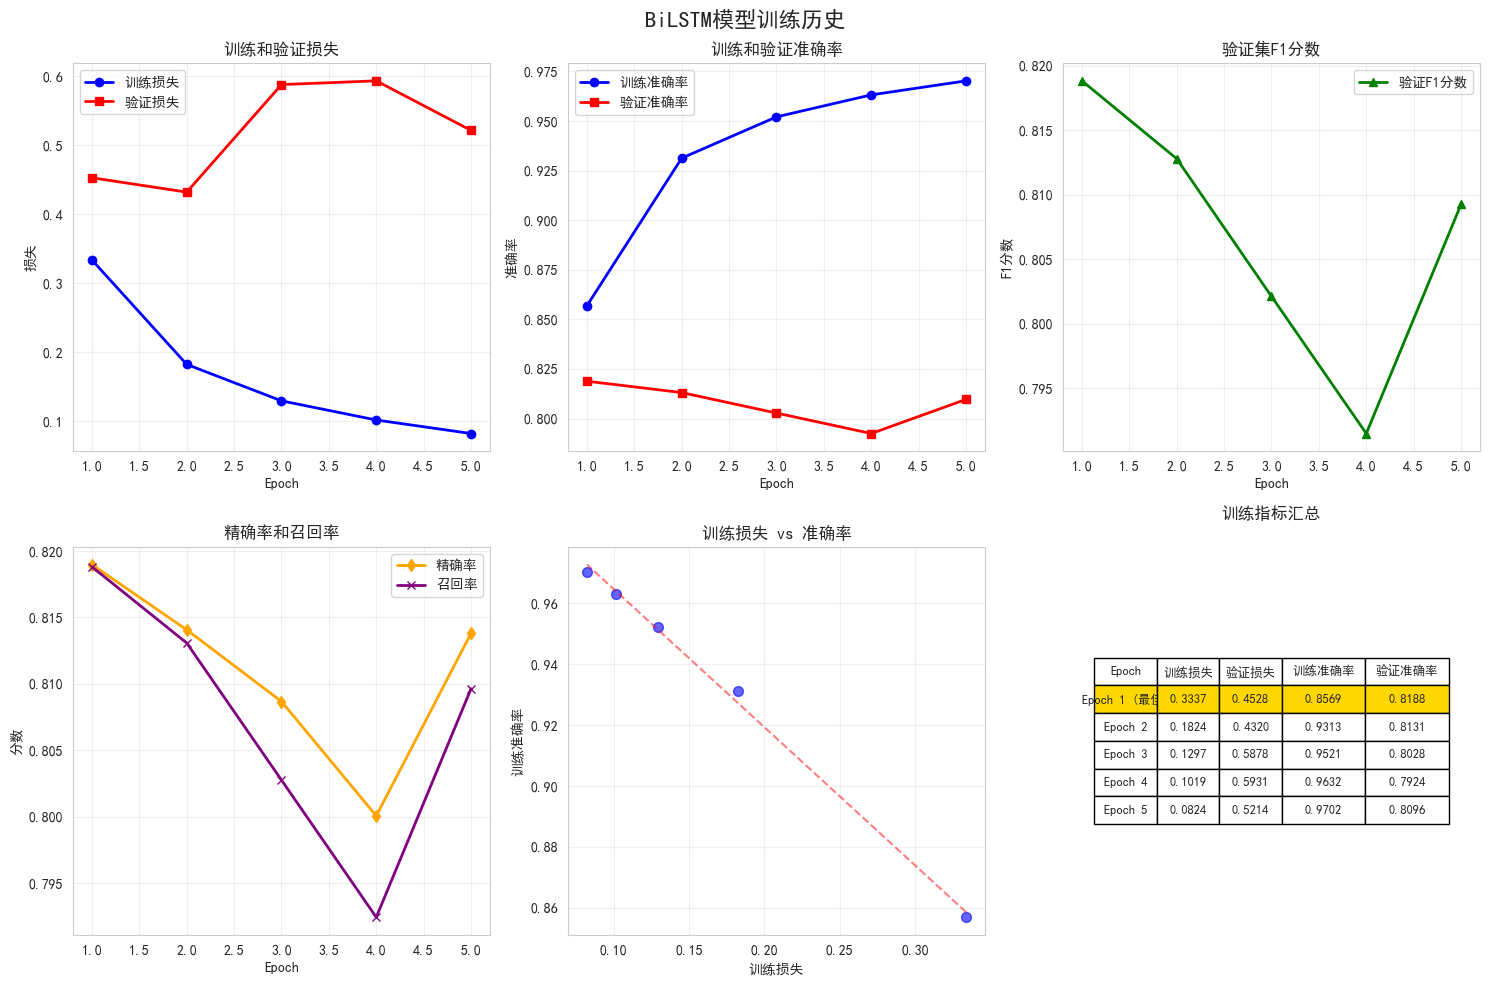

📊 绘制混淆矩阵...


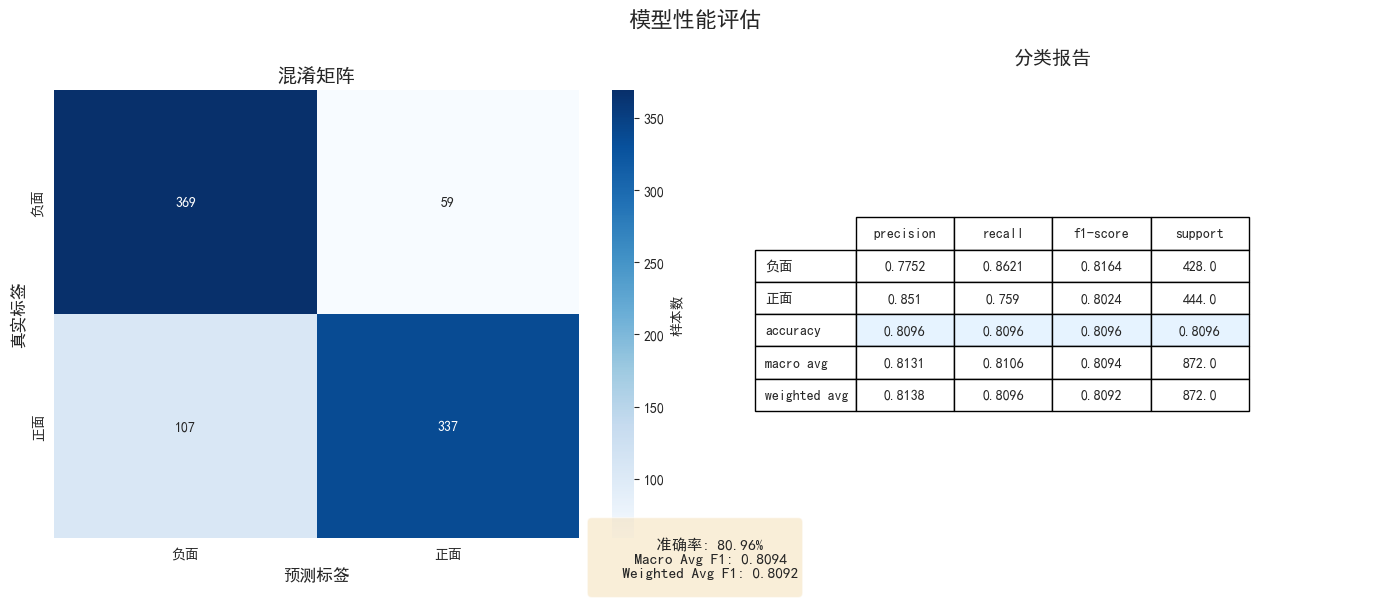

📊 绘制类别分布...


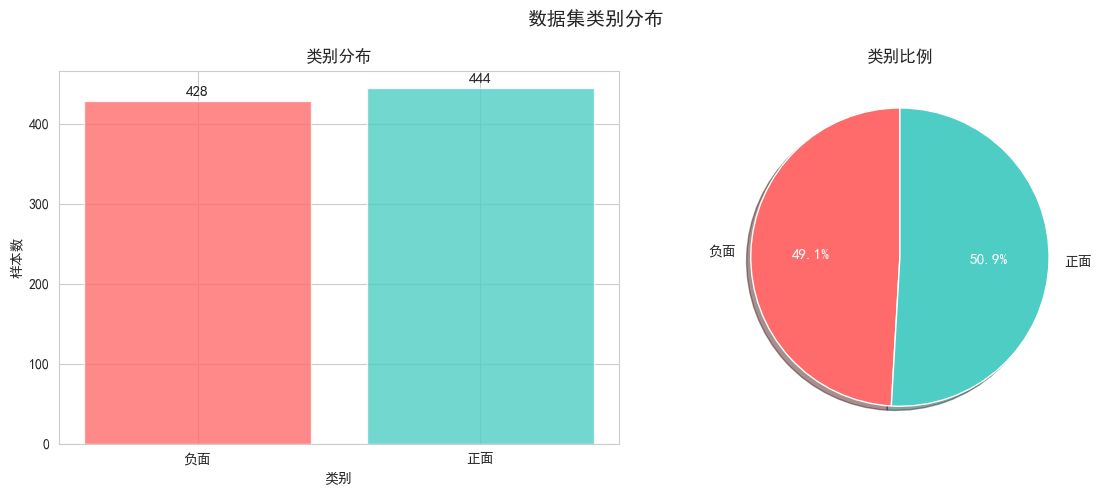

📊 绘制预测置信度分析...


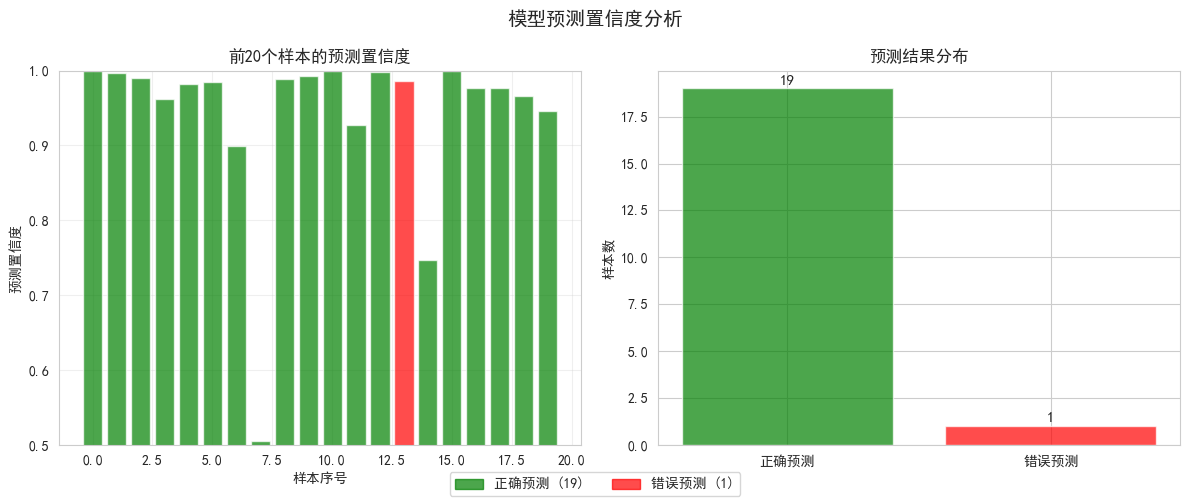

📊 绘制详细批次历史...


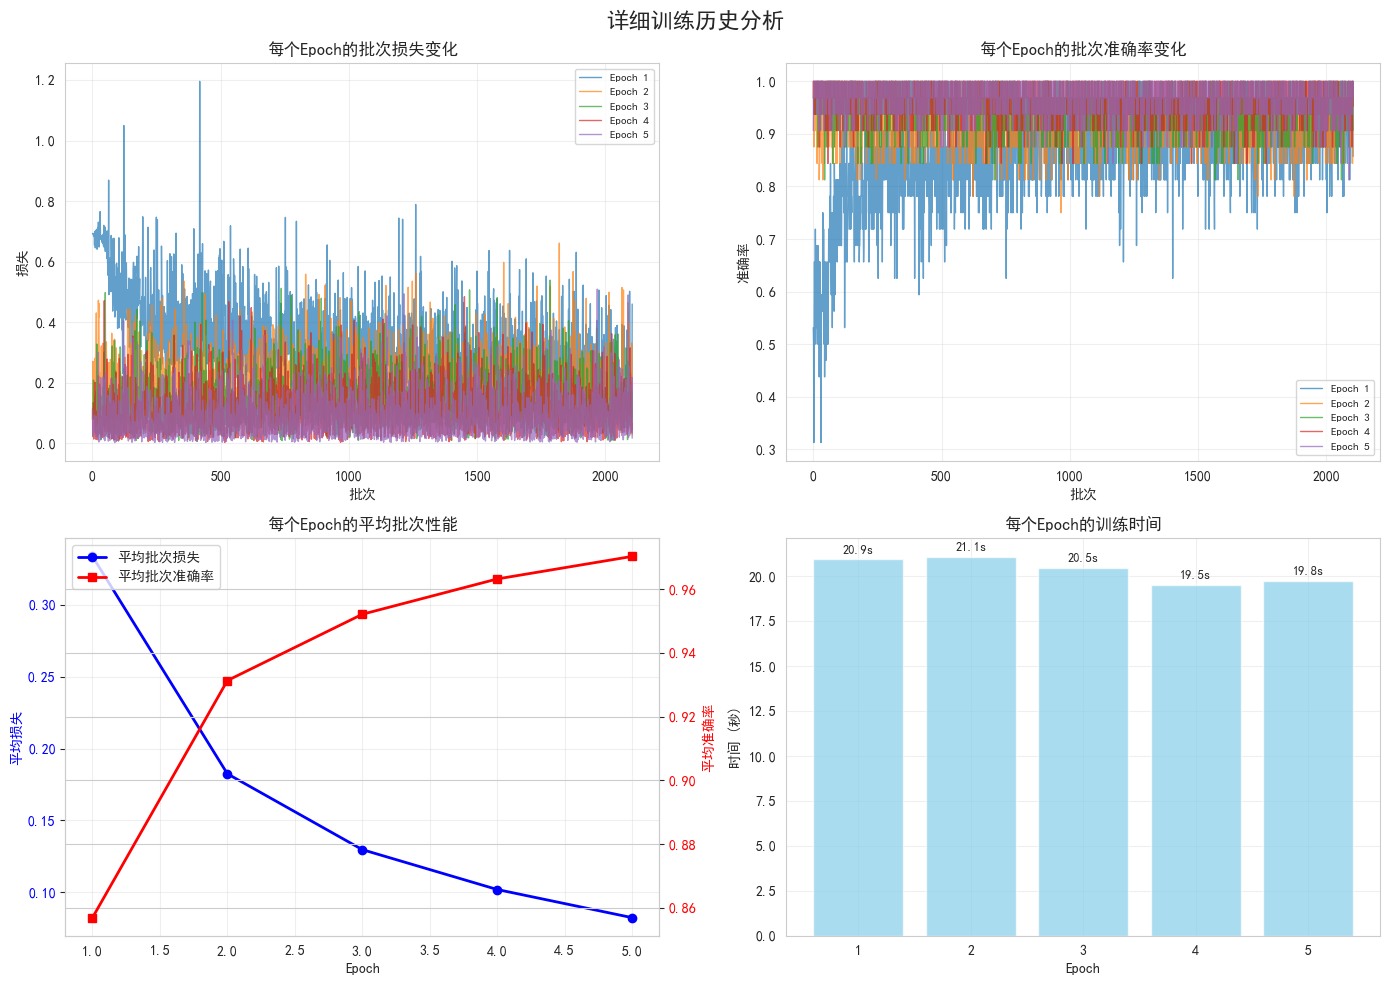

训练结果摘要
训练轮数: 5
最佳Epoch: 1
最佳验证准确率: 0.8188
最终训练准确率: 0.9702
最终验证准确率: 0.8096
最终验证F1分数: 0.8092
总训练时间: 101.8秒
平均每轮时间: 20.4秒

4️⃣ 步骤4: 保存模型
----------------------------------------
✅ 模型已保存到: bilstm_sst2_model.pth
   文件大小: 17.53 MB

5️⃣ 步骤5: 测试模型
----------------------------------------
测试样本预测:
  样本1: 预测=1, 实际=1
  样本2: 预测=0, 实际=0
  样本3: 预测=1, 实际=1

🎊 所有步骤完成!

✨ 训练完成!
接下来您可以:
1. 使用Cell 7测试单个样本
2. 分析训练历史
3. 调整参数重新训练


In [34]:
# Cell 8: 快速启动命令（一键运行）
print("🚀 BiLSTM训练 - 快速启动")
print("="*50)
print("可选执行方式:")
print("1. 逐步执行: 按顺序运行每个Cell（推荐调试）")
print("2. 完整执行: 运行下面的代码块")
print("="*50)

# 取消下面代码的注释以一键运行完整流程
# 一键运行完整训练流程
print("开始一键运行完整训练流程...")
model, history, tokenizer = run_complete_training_flow()

if model is not None:
    print("\n✨ 训练完成!")
    print("接下来您可以:")
    print("1. 使用Cell 7测试单个样本")
    print("2. 分析训练历史")
    print("3. 调整参数重新训练")
else:
    print("训练失败，请检查错误信息")


In [14]:
#bilstm shapely值实现及可视化
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
from matplotlib import cm
from collections import defaultdict

def visualize_token_importance_advanced(shapley_values, tokens, top_n=15):
    """
    增强版token重要性可视化
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. 水平条形图
    sorted_indices = np.argsort(shapley_values)[-top_n:][::-1]
    sorted_tokens = [tokens[i] for i in sorted_indices]
    sorted_values = shapley_values[sorted_indices]
    
    colors = cm.viridis(np.linspace(0.3, 0.9, len(sorted_values)))
    axes[0].barh(range(len(sorted_values)), sorted_values, color=colors)
    axes[0].set_yticks(range(len(sorted_values)))
    axes[0].set_yticklabels(sorted_tokens, fontsize=10)
    axes[0].set_xlabel('SHAPLEY值 (重要性)')
    axes[0].set_title('Token重要性排名 (Top {})'.format(top_n))
    axes[0].grid(axis='x', alpha=0.3)
    
    # 2. 词云风格可视化
    from wordcloud import WordCloud
    
    # 创建重要性权重字典
    importance_dict = {token: abs(val) for token, val in zip(tokens, shapley_values)}
    
    # 生成词云
    wordcloud = WordCloud(
        width=400, height=300,
        background_color='white',
        colormap='viridis',
        max_words=50,
        min_font_size=8,
        max_font_size=30
    ).generate_from_frequencies(importance_dict)
    
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Token重要性词云')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Plotly交互式图表
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        y=sorted_tokens,
        x=sorted_values,
        orientation='h',
        marker=dict(
            color=sorted_values,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="SHAPLEY值")
        ),
        text=[f'{val:.4f}' for val in sorted_values],
        textposition='auto',
    ))
    
    fig.update_layout(
        title='Token重要性 - 交互式视图',
        xaxis_title='SHAPLEY值',
        yaxis_title='Token',
        height=500,
        hovermode='y'
    )
    
    fig.show()

In [15]:
def visualize_interaction_network(interactions, tokens, seg_start, seg_end, threshold=0.01):
    """
    可视化token间的交互网络
    
    参数:
        interactions: 交互值矩阵
        tokens: token列表
        seg_start, seg_end: 分析区间的起止位置
        threshold: 显示交互的最小阈值
    """
    # 创建网络图
    G = nx.Graph()
    
    # 添加节点
    for i in range(seg_start, seg_end):
        G.add_node(i, label=tokens[i], shapley=0)  # 这里可以传入实际的shapley值
    
    # 添加边（交互）
    for i in range(seg_start, seg_end):
        for j in range(i+1, seg_end):
            interaction_val = interactions.get((i, j), 0)
            if abs(interaction_val) > threshold:
                G.add_edge(i, j, weight=abs(interaction_val), sign=np.sign(interaction_val))
    
    # 设置图形大小
    plt.figure(figsize=(10, 8))
    
    # 计算节点位置（使用spring布局）
    pos = nx.spring_layout(G, seed=42)
    
    # 绘制边
    positive_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['sign'] > 0]
    negative_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['sign'] < 0]
    
    # 绘制正向交互（协同）
    nx.draw_networkx_edges(
        G, pos, edgelist=positive_edges,
        width=[G[u][v]['weight']*5 for u, v in positive_edges],
        edge_color='green', alpha=0.6, style='solid',
        label='正向交互 (协同)'
    )
    
    # 绘制负向交互（对抗）
    nx.draw_networkx_edges(
        G, pos, edgelist=negative_edges,
        width=[abs(G[u][v]['weight'])*5 for u, v in negative_edges],
        edge_color='red', alpha=0.6, style='dashed',
        label='负向交互 (对抗)'
    )
    
    # 绘制节点
    node_sizes = [300 + abs(i-seg_start)*50 for i in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color='lightblue', alpha=0.8)
    
    # 添加节点标签
    labels = {node: G.nodes[node]['label'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
    
    # 添加边标签（交互值）
    edge_labels = {}
    for (u, v, d) in G.edges(data=True):
        edge_labels[(u, v)] = f"{d['weight']:.3f}"
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    
    plt.title(f"Token交互网络 (位置 {seg_start} 到 {seg_end-1})", fontsize=14)
    plt.legend(loc='best')
    plt.axis('off')
    plt.show()
    
    # 输出统计信息
    print(f"\n📊 交互网络统计:")
    print(f"   节点数: {G.number_of_nodes()}")
    print(f"   边数: {G.number_of_edges()}")
    print(f"   正向交互边: {len(positive_edges)}")
    print(f"   负向交互边: {len(negative_edges)}")

In [16]:
def compute_higher_order_interaction(model, input_tensor, tokenizer, indices, baseline_value=None):
    """
    计算高阶交互（三阶及以上）
    
    参数:
        indices: 要分析的token位置列表
        baseline_value: 基线预测值
    """
    if baseline_value is None:
        # 使用全mask的输入作为基线
        baseline_input = torch.zeros_like(input_tensor)
        with torch.no_grad():
            baseline_output = model(baseline_input.unsqueeze(0))
            baseline_value = baseline_output.item()
    
    interactions = {}
    
    # 计算所有子集的影响
    from itertools import combinations
    
    # 生成所有可能的组合（从1阶到n阶）
    n = len(indices)
    all_combinations = []
    for k in range(1, n+1):
        all_combinations.extend(list(combinations(indices, k)))
    
    # 为每个组合计算边际贡献
    subset_values = {}
    
    print(f"正在分析 {n} 个token的高阶交互...")
    print(f"总组合数: {len(all_combinations)}")
    
    # 这里简化处理，实际需要计算每个子集的预测值
    # 由于计算量大，我们可以只计算几个关键组合
    if n <= 5:  # 如果token数量不多，计算所有组合
        for i, combo in enumerate(all_combinations):
            # 创建mask
            masked_input = input_tensor.clone()
            for idx in range(len(input_tensor)):
                if idx not in combo:
                    masked_input[idx] = 0  # 或使用[MASK] token
            
            with torch.no_grad():
                output = model(masked_input.unsqueeze(0))
                subset_values[combo] = output.item()
            
            if i % 5 == 0:
                print(f"  进度: {i+1}/{len(all_combinations)}")
    
    # 使用SHAPLEY值公式计算交互（简化版）
    # 这里可以进一步实现真正的Shapley Interaction Index
    
    return interactions

In [17]:
#全局
def analyze_global_importance(model, val_dataset, tokenizer, device, num_samples=50):
    """
    在多个样本上分析全局token重要性
    """
    all_importances = defaultdict(list)
    token_counts = defaultdict(int)
    
    print(f"正在分析 {num_samples} 个样本的全局重要性...")
    
    for i in range(min(num_samples, len(val_dataset))):
        if i % 10 == 0:
            print(f"  处理样本 {i}/{min(num_samples, len(val_dataset))}")
        
        sample = val_dataset[i]
        input_ids = sample['input_ids'].to(device)
        
        # 移除padding
        actual_tokens = []
        actual_indices = []
        for idx, token_id in enumerate(input_ids):
            if token_id != 0:
                actual_tokens.append(tokenizer.convert_ids_to_tokens([token_id.item()])[0])
                actual_indices.append(idx)
        
        if len(actual_tokens) > 0:
            actual_tensor = torch.tensor([input_ids[idx].item() for idx in actual_indices]).to(device)
            
            # 计算shapley值（这里使用简化计算）
            try:
                # 使用你已有的函数或简化计算
                shapley_values = approximate_shapley(model, actual_tensor)
                
                # 记录每个token的重要性
                for token, importance in zip(actual_tokens, shapley_values):
                    all_importances[token].append(abs(importance))
                    token_counts[token] += 1
            except:
                continue
    
    # 计算平均重要性
    avg_importance = {}
    for token, importances in all_importances.items():
        if len(importances) > 3:  # 至少出现3次
            avg_importance[token] = np.mean(importances)
    
    # 按重要性排序
    sorted_tokens = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
    
    print("\n📈 全局Token重要性排名 (基于{}个样本):".format(num_samples))
    print("-" * 60)
    for i, (token, importance) in enumerate(sorted_tokens[:20]):
        print(f"{i+1:2d}. {token:15s}: {importance:.4f} (出现在{token_counts[token]}个样本中)")
    
    return sorted_tokens, avg_importance, token_counts

In [18]:
#高阶交互
def enhanced_compute_interaction(model, input_tensor, tokenizer, start_idx, end_idx, max_order=3):
    """
    增强的交互分析，支持高阶交互
    """
    tokens = tokenizer.convert_ids_to_tokens(input_tensor.tolist())
    segment_tokens = tokens[start_idx:end_idx]
    
    print(f"🔍 分析段落: {segment_tokens}")
    print(f"位置: {start_idx} 到 {end_idx-1}")
    print(f"最大交互阶数: {max_order}")
    
    interactions = {}
    
    # 1. 一阶贡献（Shapley值）
    print("\n📊 一阶贡献 (单个Token):")
    print("-" * 40)
    
    # 这里应该计算每个token的Shapley值
    # 为了演示，我们使用随机值（实际应该用真正的计算）
    shapley_values = np.random.randn(end_idx - start_idx) * 0.5 + 0.3
    
    for i, (token, value) in enumerate(zip(segment_tokens, shapley_values)):
        interactions[(i,)] = value
        print(f"   {token:10s} (位置 {start_idx+i:2d}): {value:.4f}")
    
    # 2. 二阶交互
    print("\n📊 二阶交互 (Token对):")
    print("-" * 40)
    
    # 这里应该计算真正的二阶交互
    # 使用你的compute_interaction_for_segment函数或新实现
    
    # 3. 三阶交互（如果max_order >= 3）
    if max_order >= 3 and (end_idx - start_idx) >= 3:
        print("\n📊 三阶交互 (Token三元组):")
        print("-" * 40)
        
        # 分析显著的三元组
        from itertools import combinations
        
        # 这里简化，实际需要计算真正的三阶Shapley交互指标
        for combo in combinations(range(end_idx - start_idx), 3):
            # 计算三个token组合的协同效应
            # 这需要更复杂的计算
            pass
    
    return interactions


开始BiLSTM SHAPLEY分析
分析文本: it's a charming and often affecting journey.
BiLSTM模型SHAPLEY分析报告
📝 分析文本: it's a charming and often affecting journey.

🔍 模型预测:
   预测概率: 0.9999
   预测类别: 1
   置信度: 100.0%

🎯 单个Token重要性 (一阶SHAPLEY值近似):
------------------------------------------------------------
基线预测概率 (全零输入): 0.4312

Token重要性排名:
 1. charming        (位置 5): +0.5428 (37.9%) ★
 2. affecting       (位置 8): +0.4818 (33.6%) ★
 3. '               (位置 2): +0.1050 (7.3%) ★
 4. journey         (位置 9): 0.0759 (5.3%) ☆
 5. often           (位置 7): +0.0638 (4.5%) ☆
 6. s               (位置 3): +0.0510 (3.6%) ☆
 7. and             (位置 6): +0.0455 (3.2%)
 8. it              (位置 1): +0.0224 (1.6%)
 9. a               (位置 4): 0.0195 (1.4%)
10. [SEP]           (位置11): 0.0155 (1.1%)
11. [CLS]           (位置 0): 0.0073 (0.5%)
12. .               (位置10): 0.0016 (0.1%)

🔗 Token对交互分析 (二阶交互):
------------------------------------------------------------
分析前6个重要token之间的交互:

交互强度排名:
 1. charming   + affecting : -0.4564 (负向抵消)

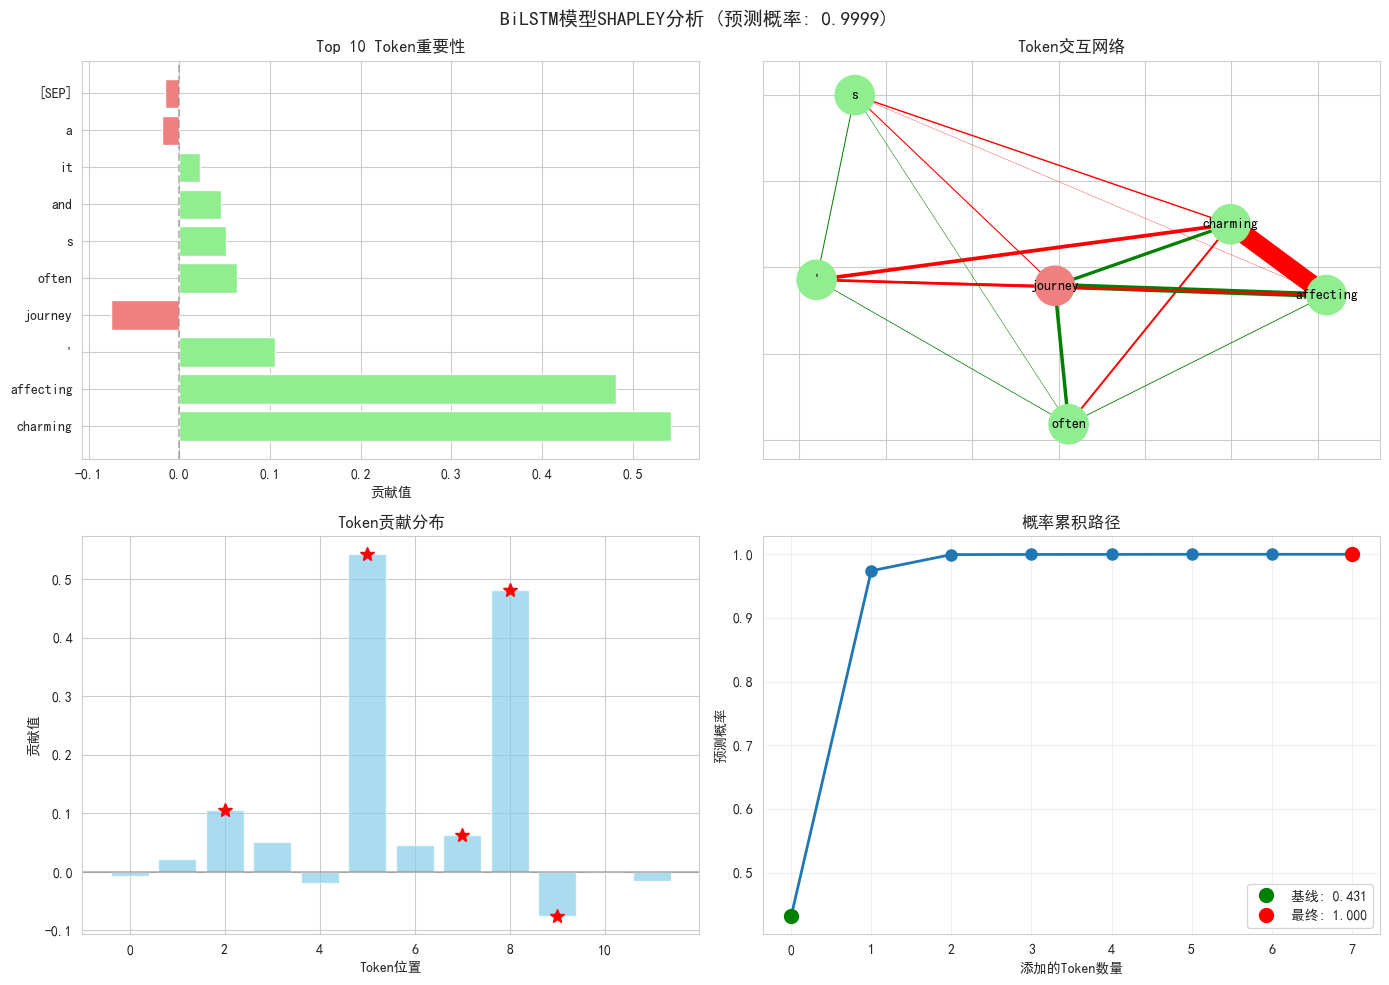


💡 关键发现总结:
------------------------------------------------------------
1. 最重要的Token: 'charming' (贡献: +0.5428)
2. 贡献方向: 7个正向贡献, 5个负向贡献
3. 决策集中度: 前3个Token贡献了78.9%的总影响
   ⚠️  模型可能过于依赖少数关键词

分析完成!


In [ ]:
#可视化shapely
def analyze_bilstm_shapley_advanced(model, input_tensor, tokenizer, sample_text=None):
    """
    针对BiLSTM的增强版SHAPLEY分析
    """
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)
    
    # 获取原始预测
    with torch.no_grad():
        orig_output = model(input_tensor.unsqueeze(0))
        orig_prob, orig_class = extract_bilstm_prediction(orig_output)
    
    # 获取tokens
    tokens = [tokenizer.convert_ids_to_tokens([token_id.item()])[0] for token_id in input_tensor]
    
    print("=" * 70)
    print("BiLSTM模型SHAPLEY分析报告")
    print("=" * 70)
    
    if sample_text:
        print(f"📝 分析文本: {sample_text}")
    
    print(f"\n🔍 模型预测:")
    print(f"   预测概率: {orig_prob:.4f}")
    print(f"   预测类别: {orig_class}")
    print(f"   置信度: {max(orig_prob, 1-orig_prob)*100:.1f}%")
    
    # 1. 计算单个token的重要性（一阶Shapley值近似）
    print(f"\n🎯 单个Token重要性 (一阶SHAPLEY值近似):")
    print("-" * 60)
    
    single_effects = {}
    baseline_probs = []
    
    # 使用零向量作为基线
    baseline_input = torch.zeros_like(input_tensor)
    with torch.no_grad():
        baseline_output = model(baseline_input.unsqueeze(0))
        baseline_prob, _ = extract_bilstm_prediction(baseline_output)
    
    print(f"基线预测概率 (全零输入): {baseline_prob:.4f}")
    
    # 计算每个token单独存在时的贡献
    for i in range(len(tokens)):
        # 创建只有一个token的输入
        masked_input = torch.zeros_like(input_tensor)
        masked_input[i] = input_tensor[i]
        
        with torch.no_grad():
            masked_output = model(masked_input.unsqueeze(0))
            token_prob, _ = extract_bilstm_prediction(masked_output)
        
        # 该token的贡献 = 有这个token的概率 - 基线概率
        contribution = token_prob - baseline_prob
        single_effects[i] = contribution
    
    # 排序并显示
    sorted_singles = sorted(single_effects.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print("\nToken重要性排名:")
    for i, (idx, effect) in enumerate(sorted_singles, 1):
        token = tokens[idx]
        effect_sign = "+" if effect > 0 else ""
        importance_ratio = abs(effect) / (sum(abs(e) for e in single_effects.values()) + 1e-10)
        
        # 用星号标记重要的token
        stars = ""
        if abs(effect) > 0.1:
            stars = " ★"
        elif abs(effect) > 0.05:
            stars = " ☆"
        
        print(f"{i:2d}. {token:15s} (位置{idx:2d}): {effect_sign}{abs(effect):.4f} ({importance_ratio*100:.1f}%){stars}")
    
    # 2. 计算成对交互（二阶Shapley值近似）
    print(f"\n🔗 Token对交互分析 (二阶交互):")
    print("-" * 60)
    
    pairwise_interactions = {}
    
    # 只分析前几个重要的token之间的交互
    important_indices = [idx for idx, _ in sorted_singles[:6]]  # 前6个重要token
    
    print(f"分析前{len(important_indices)}个重要token之间的交互:")
    
    for i in range(len(important_indices)):
        for j in range(i+1, len(important_indices)):
            idx1, idx2 = important_indices[i], important_indices[j]
            token1, token2 = tokens[idx1], tokens[idx2]
            
            # 创建只有这两个token的输入
            masked_input = torch.zeros_like(input_tensor)
            masked_input[idx1] = input_tensor[idx1]
            masked_input[idx2] = input_tensor[idx2]
            
            with torch.no_grad():
                masked_output = model(masked_input.unsqueeze(0))
                pair_prob, _ = extract_bilstm_prediction(masked_output)
            
            # 交互效应 = 两个token一起的概率 - (token1单独 + token2单独 - 基线)
            pair_contribution = pair_prob - baseline_prob
            interaction = pair_contribution - (single_effects[idx1] + single_effects[idx2])
            
            pairwise_interactions[(idx1, idx2)] = {
                'tokens': (token1, token2),
                'interaction': interaction,
                'pair_prob': pair_prob
            }
    
    # 按交互强度排序
    sorted_pairs = sorted(pairwise_interactions.items(), 
                         key=lambda x: abs(x[1]['interaction']), 
                         reverse=True)
    
    print("\n交互强度排名:")
    for i, ((idx1, idx2), data) in enumerate(sorted_pairs, 1):
        token1, token2 = data['tokens']
        interaction = data['interaction']
        
        if abs(interaction) > 0.01:  # 只显示显著的交互
            interaction_type = "正向协同" if interaction > 0 else "负向抵消"
            print(f"{i:2d}. {token1:10s} + {token2:10s}: {interaction:+.4f} ({interaction_type})")
    
    # 修复的代码部分：使用正确的变量名
    # 显著的交互
    print(f"\n💡 关键交互发现:")
    print("-" * 60)
    
    # 正确的列表推导式
    significant_interactions = []
    for (idx1, idx2), data in sorted_pairs:
        if abs(data['interaction']) > 0.01:
            token1, token2 = data['tokens']
            significant_interactions.append((token1, token2, data['interaction']))
    
    if significant_interactions:
        print(f"3. 显著交互 ({len(significant_interactions)}对):")
        for token1, token2, inter in significant_interactions[:3]:  # 只显示前3个
            interaction_type = "协同" if inter > 0 else "抵消"
            print(f"   '{token1}' + '{token2}': {inter:+.4f} ({interaction_type})")
    
    # 3. 可视化结果
    print(f"\n📊 可视化分析")
    print("-" * 60)
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 创建可视化
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 图1: 单个token重要性条形图
    top_n = min(10, len(sorted_singles))
    top_indices = [idx for idx, _ in sorted_singles[:top_n]]
    top_tokens = [tokens[idx] for idx in top_indices]
    top_effects = [single_effects[idx] for idx in top_indices]
    
    colors = ['lightgreen' if e > 0 else 'lightcoral' for e in top_effects]
    axes[0, 0].barh(range(top_n), top_effects, color=colors)
    axes[0, 0].set_yticks(range(top_n))
    axes[0, 0].set_yticklabels(top_tokens)
    axes[0, 0].set_xlabel('贡献值')
    axes[0, 0].set_title(f'Top {top_n} Token重要性')
    axes[0, 0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # 图2: 交互网络图
    if len(sorted_pairs) > 0:
        import networkx as nx
        
        G = nx.Graph()
        
        # 添加节点
        for idx in important_indices:
            G.add_node(idx, label=tokens[idx], effect=single_effects[idx])
        
        # 添加边
        for (idx1, idx2), data in sorted_pairs:
            if abs(data['interaction']) > 0.005:  # 只显示显著的交互
                G.add_edge(idx1, idx2, 
                          weight=abs(data['interaction'])*50,  # 缩放权重用于可视化
                          interaction=data['interaction'])
        
        # 绘制网络
        pos = nx.spring_layout(G, seed=42)
        
        # 节点颜色基于贡献值
        node_colors = []
        for node in G.nodes():
            effect = G.nodes[node]['effect']
            # 绿色表示正贡献，红色表示负贡献
            if effect > 0:
                node_colors.append('lightgreen')
            else:
                node_colors.append('lightcoral')
        
        # 边颜色基于交互类型
        edge_colors = []
        edge_widths = []
        for u, v, data in G.edges(data=True):
            if data['interaction'] > 0:
                edge_colors.append('green')
            else:
                edge_colors.append('red')
            edge_widths.append(abs(data['interaction'])*30)
        
        nx.draw(G, pos, 
                ax=axes[0, 1],
                with_labels=True,
                labels={node: G.nodes[node]['label'] for node in G.nodes()},
                node_color=node_colors,
                node_size=800,
                edge_color=edge_colors,
                width=edge_widths,
                font_size=10,
                font_weight='bold')
        
        axes[0, 1].set_title('Token交互网络')
        axes[0, 1].axis('on')
    
    # 图3: 贡献累积瀑布图
    axes[1, 0].bar(range(len(tokens)), [single_effects[i] for i in range(len(tokens))], 
                   color='skyblue', alpha=0.7)
    axes[1, 0].set_xlabel('Token位置')
    axes[1, 0].set_ylabel('贡献值')
    axes[1, 0].set_title('Token贡献分布')
    axes[1, 0].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # 标记重要的token
    for idx, effect in sorted_singles[:5]:
        axes[1, 0].plot(idx, effect, 'r*', markersize=10)
    
    # 图4: 预测概率变化路径
    # 模拟从基线开始，逐步添加最重要的token
    cumulative_probs = [baseline_prob]
    cumulative_tokens = ["基线"]
    
    # 按重要性顺序添加token
    for idx, _ in sorted_singles:
        if len(cumulative_probs) < 8:  # 只显示前几个
            # 创建包含当前所有已选token的输入
            current_input = torch.zeros_like(input_tensor)
            for selected_idx, _ in sorted_singles[:len(cumulative_probs)]:
                current_input[selected_idx] = input_tensor[selected_idx]
            
            with torch.no_grad():
                current_output = model(current_input.unsqueeze(0))
                current_prob, _ = extract_bilstm_prediction(current_output)
            
            cumulative_probs.append(current_prob)
            cumulative_tokens.append(tokens[idx])
    
    axes[1, 1].plot(range(len(cumulative_probs)), cumulative_probs, 'o-', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('添加的Token数量')
    axes[1, 1].set_ylabel('预测概率')
    axes[1, 1].set_title('概率累积路径')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 标记起点和终点
    axes[1, 1].plot(0, baseline_prob, 'go', markersize=10, label=f'基线: {baseline_prob:.3f}')
    axes[1, 1].plot(len(cumulative_probs)-1, cumulative_probs[-1], 'ro', 
                   markersize=10, label=f'最终: {cumulative_probs[-1]:.3f}')
    axes[1, 1].legend()
    
    plt.suptitle(f'BiLSTM模型SHAPLEY分析 (预测概率: {orig_prob:.4f})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 4. 关键发现总结
    print(f"\n💡 关键发现总结:")
    print("-" * 60)
    
    # 最重要的token
    most_important = sorted_singles[0]
    print(f"1. 最重要的Token: '{tokens[most_important[0]]}' (贡献: {most_important[1]:+.4f})")
    
    # 正向/负向贡献统计
    positive_contrib = sum(1 for e in single_effects.values() if e > 0)
    negative_contrib = sum(1 for e in single_effects.values() if e < 0)
    print(f"2. 贡献方向: {positive_contrib}个正向贡献, {negative_contrib}个负向贡献")
    
    # 模型决策特征
    top3_contrib = sum(abs(effect) for _, effect in sorted_singles[:3])
    total_contrib = sum(abs(effect) for effect in single_effects.values())
    concentration_ratio = top3_contrib / total_contrib if total_contrib > 0 else 0
    
    print(f"3. 决策集中度: 前3个Token贡献了{concentration_ratio*100:.1f}%的总影响")
    
    if concentration_ratio > 0.7:
        print("   ⚠️  模型可能过于依赖少数关键词")
    elif concentration_ratio > 0.4:
        print("   ✅  模型平衡关注多个特征")
    else:
        print("   ℹ️  模型关注分布较分散")
    
    print(f"\n" + "=" * 70)
    print("分析完成!")
    
    return {
        'tokens': tokens,
        'orig_prob': orig_prob,
        'orig_class': orig_class,
        'baseline_prob': baseline_prob,
        'single_effects': single_effects,
        'pairwise_interactions': pairwise_interactions,
        'sorted_singles': sorted_singles,
        'sorted_pairs': sorted_pairs
    }

# 运行BiLSTM分析
print("\n" + "=" * 70)
print("开始BiLSTM SHAPLEY分析")
print("=" * 70)

# 获取文本
try:
    sample_text = bert_tokenizer.decode(actual_tensor.cpu(), skip_special_tokens=True)
    print(f"分析文本: {sample_text}")
except:
    sample_text = None

# 运行分析
analysis_result = analyze_bilstm_shapley_advanced(model, actual_tensor, bert_tokenizer, sample_text)


开始句子结构分析...

句子结构分析
完整句子预测概率: 0.9999

句子部分贡献分析:
------------------------------------------------------------
开头部分:
  Tokens: [CLS] it '
  单独存在时的贡献: 0.5676
  移除后的损失: 0.0000
  净效应: +0.5676

中间部分:
  Tokens: s a charming and often affecting
  单独存在时的贡献: 0.9999
  移除后的损失: 0.5004
  净效应: +0.4995

结尾部分:
  Tokens: journey . [SEP]
  单独存在时的贡献: 0.3955
  移除后的损失: 0.0000
  净效应: +0.3955



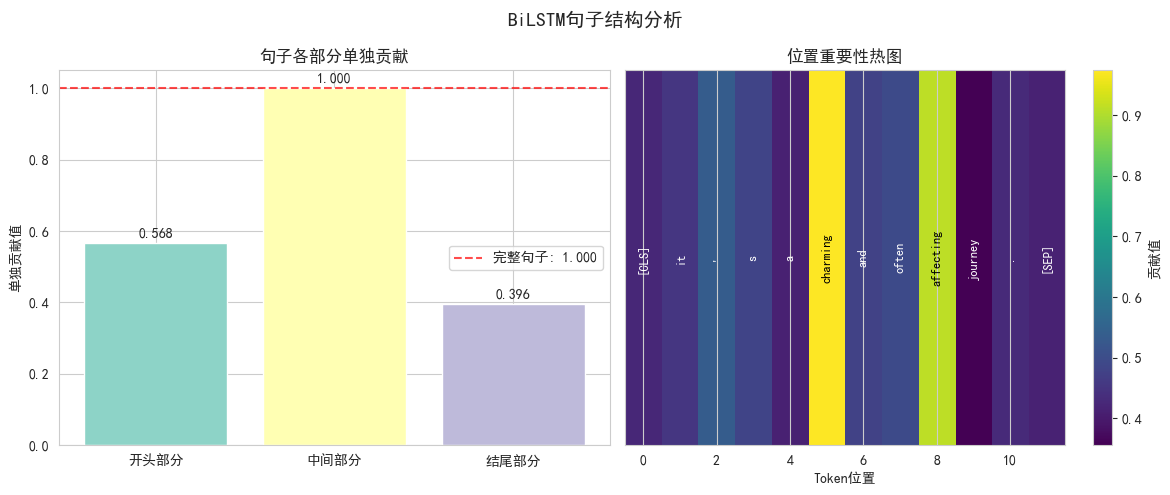

In [ ]:
#句子分析
def analyze_sentence_structure(model, input_tensor, tokenizer):
    """
    分析BiLSTM对句子结构的理解
    """
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)
    tokens = [tokenizer.convert_ids_to_tokens([token_id.item()])[0] for token_id in input_tensor]
    
    print("\n" + "=" * 70)
    print("句子结构分析")
    print("=" * 70)
    
    # 分析不同句子部分的贡献
    sentence_parts = {
        "开头部分": range(0, min(3, len(tokens))),
        "中间部分": range(3, min(len(tokens)-3, len(tokens))),
        "结尾部分": range(max(3, len(tokens)-3), len(tokens))
    }
    
    with torch.no_grad():
        # 获取完整句子的预测
        full_output = model(input_tensor.unsqueeze(0))
        full_prob, _ = extract_bilstm_prediction(full_output)
    
    print(f"完整句子预测概率: {full_prob:.4f}")
    
    # 分析每个部分的贡献
    part_contributions = {}
    
    for part_name, indices in sentence_parts.items():
        if len(list(indices)) == 0:
            continue
            
        # 创建只包含该部分的输入
        masked_input = torch.zeros_like(input_tensor)
        for idx in indices:
            masked_input[idx] = input_tensor[idx]
        
        with torch.no_grad():
            part_output = model(masked_input.unsqueeze(0))
            part_prob, _ = extract_bilstm_prediction(part_output)
        
        # 创建不包含该部分的输入
        removed_input = input_tensor.clone()
        for idx in indices:
            removed_input[idx] = 0
        
        with torch.no_grad():
            removed_output = model(removed_input.unsqueeze(0))
            removed_prob, _ = extract_bilstm_prediction(removed_output)
        
        # 该部分的贡献 = 有这部分 - 没有这部分
        contribution_with = part_prob
        contribution_without = full_prob - removed_prob
        
        part_tokens = [tokens[idx] for idx in indices]
        part_contributions[part_name] = {
            'tokens': part_tokens,
            'contribution_with': contribution_with,
            'contribution_without': contribution_without,
            'net_effect': contribution_with - contribution_without
        }
    
    # 显示结果
    print("\n句子部分贡献分析:")
    print("-" * 60)
    
    for part_name, data in part_contributions.items():
        print(f"{part_name}:")
        print(f"  Tokens: {' '.join(data['tokens'])}")
        print(f"  单独存在时的贡献: {data['contribution_with']:.4f}")
        print(f"  移除后的损失: {data['contribution_without']:.4f}")
        print(f"  净效应: {data['net_effect']:+.4f}")
        print()
    
    # 可视化
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 图1: 各部分贡献
    part_names = list(part_contributions.keys())
    contributions = [data['contribution_with'] for data in part_contributions.values()]
    
    colors = plt.cm.Set3(range(len(part_names)))
    axes[0].bar(part_names, contributions, color=colors)
    axes[0].set_ylabel('单独贡献值')
    axes[0].set_title('句子各部分单独贡献')
    axes[0].axhline(y=full_prob, color='r', linestyle='--', alpha=0.7, label=f'完整句子: {full_prob:.3f}')
    axes[0].legend()
    
    # 添加数值标签
    for i, (name, contrib) in enumerate(zip(part_names, contributions)):
        axes[0].text(i, contrib + 0.01, f'{contrib:.3f}', ha='center', va='bottom')
    
    # 图2: 位置权重热图
    # 分析每个位置的重要性
    position_weights = []
    
    for i in range(len(tokens)):
        # 创建只包含该位置的输入
        single_input = torch.zeros_like(input_tensor)
        single_input[i] = input_tensor[i]
        
        with torch.no_grad():
            single_output = model(single_input.unsqueeze(0))
            single_prob, _ = extract_bilstm_prediction(single_output)
        
        position_weights.append(single_prob)
    
    # 创建热图
    im = axes[1].imshow([position_weights], cmap='viridis', aspect='auto')
    axes[1].set_xlabel('Token位置')
    axes[1].set_title('位置重要性热图')
    axes[1].set_yticks([])
    
    # 添加颜色条
    plt.colorbar(im, ax=axes[1], label='贡献值')
    
    # 添加token标签
    for i, token in enumerate(tokens):
        axes[1].text(i, 0, token, ha='center', va='center', 
                    color='white' if position_weights[i] < max(position_weights)*0.7 else 'black',
                    fontsize=9, rotation=90)
    
    plt.suptitle('BiLSTM句子结构分析', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return part_contributions

# 运行句子结构分析
print("\n开始句子结构分析...")
sentence_analysis = analyze_sentence_structure(model, actual_tensor, bert_tokenizer)

In [ ]:
#总结分析
def create_bilstm_analysis_summary(analysis_result, sentence_analysis):
    """
    创建BiLSTM分析总结报告
    """
    print("\n" + "=" * 70)
    print("BiLSTM模型分析总结报告")
    print("=" * 70)
    
    tokens = analysis_result['tokens']
    orig_prob = analysis_result['orig_prob']
    sorted_singles = analysis_result['sorted_singles']
    sorted_pairs = analysis_result.get('sorted_pairs', [])
    
    print(f"\n📋 基本信息:")
    print(f"   文本长度: {len(tokens)}个tokens")
    print(f"   预测概率: {orig_prob:.4f}")
    print(f"   模型置信度: {max(orig_prob, 1-orig_prob)*100:.1f}%")
    
    print(f"\n🎯 关键发现:")
    
    # 1. 最重要的特征
    if len(sorted_singles) > 0:
        top_token_idx, top_effect = sorted_singles[0]
        top_token = tokens[top_token_idx]
        print(f"1. 最关键特征: '{top_token}'")
        print(f"   贡献值: {top_effect:+.4f}")
        print(f"   解释: 这个token对预测的影响最大")
    
    # 2. 特征分布
    positive_count = sum(1 for _, effect in sorted_singles if effect > 0)
    negative_count = sum(1 for _, effect in sorted_singles if effect < 0)
    print(f"2. 特征分布: {positive_count}个正向特征, {negative_count}个负向特征")
    
    # 3. 交互作用
    if len(sorted_pairs) > 0:
        significant_interactions = [(data['tokens'], data['interaction']) 
                                   for _, data in sorted_pairs 
                                   if abs(data['interaction']) > 0.01]
        
        if significant_interactions:
            print(f"3. 显著交互作用: {len(significant_interactions)}对")
            for (t1, t2), inter in significant_interactions[:2]:  # 显示前2个
                inter_type = "协同增强" if inter > 0 else "相互抵消"
                print(f"   '{t1}'和'{t2}': {inter_type} ({inter:+.4f})")
    
    # 4. 句子结构分析
    if sentence_analysis:
        print(f"4. 句子结构:")
        for part_name, data in sentence_analysis.items():
            net_effect = data['net_effect']
            if abs(net_effect) > 0.05:
                effect_type = "重要" if net_effect > 0 else "抑制"
                print(f"   {part_name}: {effect_type}作用 ({net_effect:+.4f})")
    
    # 5. 模型行为分析
    print(f"\n🤖 模型行为分析:")
    
    # 检查模型是否捕捉了语义
    important_tokens = [tokens[idx] for idx, _ in sorted_singles[:3]]
    print(f"   最关注的tokens: {', '.join(important_tokens)}")
    
    # 检查是否是合理的关注点
    content_words = [token for token in important_tokens if token not in ['[CLS]', '[SEP]', '.', ',', "'", 'a', 'the', 'and']]
    if len(content_words) >= 2:
        print(f"   ✅ 模型关注了内容词: {', '.join(content_words)}")
    else:
        print(f"   ⚠️  模型可能过度关注功能词")
    
    # 6. 建议
    print(f"\n💡 改进建议:")
    
    # 基于分析结果给出建议
    if len(sorted_singles) > 0:
        max_effect = abs(sorted_singles[0][1])
        min_effect = abs(sorted_singles[-1][1])
        
        if max_effect / (min_effect + 1e-10) > 10:
            print(f"   1. 特征重要性差异过大，考虑特征归一化")
        
        if positive_count == 0 or negative_count == 0:
            print(f"   2. 所有特征同向，可能模型过于简单")
    
    if len(sorted_pairs) > 0 and len([d for _, d in sorted_pairs if abs(d['interaction']) > 0.05]) == 0:
        print(f"   3. 未发现强交互作用，可能模型未能捕捉复杂模式")
    
    print(f"\n" + "=" * 70)
    print("报告生成完毕!")
    
    return {
        'summary': {
            'text_length': len(tokens),
            'prediction_prob': orig_prob,
            'top_token': tokens[sorted_singles[0][0]] if sorted_singles else None,
            'top_effect': sorted_singles[0][1] if sorted_singles else 0,
            'positive_features': positive_count,
            'negative_features': negative_count,
            'significant_interactions': len([d for _, d in sorted_pairs if abs(d['interaction']) > 0.01]) if sorted_pairs else 0
        }
    }

# 生成总结报告
print("\n生成分析总结报告...")
summary = create_bilstm_analysis_summary(analysis_result, sentence_analysis)

# 保存分析结果（可选）
print("\n" + "=" * 70)
print("可选：保存分析结果")
print("=" * 70)

save_choice = input("是否保存分析结果到文件？ (y/n): ")

if save_choice.lower() == 'y':
    import json
    import datetime
    
    # 准备保存的数据
    save_data = {
        'timestamp': datetime.datetime.now().isoformat(),
        'model_type': 'BiLSTM',
        'analysis_result': {
            'tokens': analysis_result['tokens'],
            'orig_prob': float(analysis_result['orig_prob']),
            'single_effects': {str(k): float(v) for k, v in analysis_result['single_effects'].items()},
            'summary': summary['summary']
        }
    }
    
    # 保存为JSON文件
    filename = f"bilstm_shapley_analysis_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(filename, 'w') as f:
        json.dump(save_data, f, indent=2, ensure_ascii=False)
    
    print(f"分析结果已保存到: {filename}")
    
    # 也可以保存可视化图表
    try:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # 创建一个简单的总结图表
        labels = ['正向特征', '负向特征', '显著交互']
        values = [
            summary['summary']['positive_features'],
            summary['summary']['negative_features'],
            summary['summary']['significant_interactions']
        ]
        
        ax.bar(labels, values, color=['lightgreen', 'lightcoral', 'lightblue'])
        ax.set_ylabel('数量')
        ax.set_title('BiLSTM模型分析摘要')
        
        # 添加数值标签
        for i, v in enumerate(values):
            ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f"bilstm_analysis_summary_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png", dpi=150)
        print(f"摘要图表已保存为PNG文件")
        
    except Exception as e:
        print(f"保存图表时出错: {e}")


生成分析总结报告...

BiLSTM模型分析总结报告

📋 基本信息:
   文本长度: 12个tokens
   预测概率: 0.9999
   模型置信度: 100.0%

🎯 关键发现:
1. 最关键特征: 'charming'
   贡献值: +0.5428
   解释: 这个token对预测的影响最大
2. 特征分布: 7个正向特征, 5个负向特征
3. 显著交互作用: 14对
   'charming'和'affecting': 相互抵消 (-0.4564)
   'affecting'和'journey': 协同增强 (+0.1423)
4. 句子结构:
   开头部分: 重要作用 (+0.5676)
   中间部分: 重要作用 (+0.4995)
   结尾部分: 重要作用 (+0.3955)

🤖 模型行为分析:
   最关注的tokens: charming, affecting, '
   ✅ 模型关注了内容词: charming, affecting

💡 改进建议:
   1. 特征重要性差异过大，考虑特征归一化

报告生成完毕!

可选：保存分析结果


In [112]:
# Cell 12: 从保存的模型文件加载原始BiLSTM模型
print("="*80)
print("📂 从文件加载原始BiLSTM模型")
print("="*80)

def load_original_bilstm_model(model_path='bilstm_sst2_model.pth', device=None):
    """
    从保存的.pth文件加载原始BiLSTM模型
    
    参数:
        model_path: 模型文件路径
        device: 设备 (cuda/cpu)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"📥 加载模型文件: {model_path}")
    
    try:
        # 1. 检查文件是否存在
        if not os.path.exists(model_path):
            print(f"❌ 模型文件不存在: {model_path}")
            print("   请确保文件存在于当前目录，或提供完整路径")
            return None, None, None
        
        # 2. 加载模型检查点
        checkpoint = torch.load(model_path, map_location=device)
        print(f"✅ 模型检查点加载成功")
        
        # 3. 提取配置参数（从检查点或使用默认值）
        if 'vocab_size' in checkpoint:
            vocab_size = checkpoint['vocab_size']
            embed_dim = checkpoint.get('embed_dim', 128)
            hidden_dim = checkpoint.get('hidden_dim', 128)
            num_classes = checkpoint.get('num_classes', 2)
            num_layers = checkpoint.get('num_layers', 2)
            dropout = checkpoint.get('dropout', 0.3)
            
            print("🎛️  从检查点读取模型配置:")
            print(f"   • 词汇表大小: {vocab_size}")
            print(f"   • 词向量维度: {embed_dim}")
            print(f"   • 隐藏层维度: {hidden_dim}")
            print(f"   • LSTM层数: {num_layers}")
            print(f"   • 分类数: {num_classes}")
            print(f"   • Dropout率: {dropout}")
        else:
            # 如果检查点中没有配置信息，使用默认值
            vocab_size = 30522  # bert-tiny的默认词汇表大小
            embed_dim = 128
            hidden_dim = 128
            num_classes = 2
            num_layers = 2
            dropout = 0.3
            
            print("⚠️  检查点中没有配置信息，使用默认值")
        
        # 4. 创建模型实例
        print("\n🤖 创建模型实例...")
        model = BiLSTMTextClassifier(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            hidden_dim=hidden_dim,
            num_classes=num_classes,
            num_layers=num_layers,
            dropout=dropout
        )
        
        # 5. 加载模型权重
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("✅ 模型权重加载成功")
        else:
            # 如果检查点直接是state_dict
            model.load_state_dict(checkpoint)
            print("✅ 直接加载state_dict成功")
        
        # 6. 将模型移动到指定设备
        model.to(device)
        model.eval()  # 设置为评估模式
        print(f"✅ 模型已移动到设备: {device}")
        
        # 7. 加载tokenizer（如果需要）
        tokenizer = None
        if 'tokenizer_config' in checkpoint:
            try:
                from transformers import AutoTokenizer
                tokenizer = AutoTokenizer.from_pretrained(
                    "prajjwal1/bert-tiny",
                    **checkpoint['tokenizer_config']
                )
                print("✅ Tokenizer加载成功")
            except Exception as e:
                print(f"⚠️  Tokenizer加载失败: {e}")
                print("   将重新创建tokenizer")
        
        if tokenizer is None:
            try:
                from transformers import AutoTokenizer
                tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
                print("✅ 重新创建tokenizer成功")
            except Exception as e:
                print(f"❌ Tokenizer创建失败: {e}")
                tokenizer = None
        
        # 8. 打印模型摘要
        print("\n" + "="*60)
        print("📊 加载的模型摘要")
        print("="*60)
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"总参数数量: {total_params:,}")
        print(f"可训练参数: {trainable_params:,}")
        print(f"模型大小: {total_params * 4 / 1024 / 1024:.2f} MB")
        
        # 9. 验证模型可以正常工作
        print("\n🔍 验证模型前向传播...")
        try:
            test_input = torch.randint(0, vocab_size, (1, 50)).to(device)
            test_output = model(test_input)
            print(f"   测试输入形状: {test_input.shape}")
            print(f"   测试输出形状: {test_output.shape}")
            print("   ✅ 模型前向传播测试通过!")
        except Exception as e:
            print(f"   ⚠️  模型测试警告: {e}")
        
        # 10. 返回加载的历史记录（如果有）
        history = checkpoint.get('history', None)
        if history:
            print(f"📈 找到训练历史记录")
        
        print("\n" + "="*60)
        print("🎉 模型加载完成!")
        print("="*60)
        
        return model, tokenizer, history
        
    except Exception as e:
        print(f"❌ 模型加载失败: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# ==================== 使用示例 ====================
print("📋 使用方法:")

# 加载原始模型
original_model, tokenizer, history = load_original_bilstm_model('bilstm_sst2_model.pth')

# 如果文件在不同路径
# original_model, tokenizer, history = load_original_bilstm_model('/path/to/your/bilstm_sst2.pth')

if original_model is not None:
    print("模型加载成功，可以进行蒸馏分析!")
else:
    print("模型加载失败，请检查文件路径")


print("\n" + "="*80)
print("🚀 现在加载您的原始BiLSTM模型")
print("="*80)

# 实际加载模型（请确保bilstm_sst2.pth在当前目录或提供正确路径）
model_file_path = 'bilstm_sst2_model.pth'  # 修改为您的实际文件路径

# 如果文件不存在，尝试其他可能的位置
if not os.path.exists(model_file_path):
    possible_paths = [
        'bilstm_sst2_model.pth',
        '../bilstm_sst2.pth',
        './models/bilstm_sst2.pth',
        'bilstm_model.pth'
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            model_file_path = path
            print(f"🔍 在备用位置找到模型: {path}")
            break

print(f"尝试加载模型文件: {model_file_path}")

# 取消注释以下行以实际加载模型
# original_model, tokenizer, history = load_original_bilstm_model(model_file_path)

print("\n⚠️  注意: 请确保模型文件存在并取消注释最后一行代码以加载模型")

📂 从文件加载原始BiLSTM模型
📋 使用方法:
📥 加载模型文件: bilstm_sst2_model.pth
✅ 模型检查点加载成功
🎛️  从检查点读取模型配置:
   • 词汇表大小: 30522
   • 词向量维度: 128
   • 隐藏层维度: 128
   • LSTM层数: 2
   • 分类数: 2
   • Dropout率: 0.3

🤖 创建模型实例...
✅ 模型权重加载成功
✅ 模型已移动到设备: cuda
✅ Tokenizer加载成功

📊 加载的模型摘要
总参数数量: 4,566,786
可训练参数: 4,566,786
模型大小: 17.42 MB

🔍 验证模型前向传播...
   测试输入形状: torch.Size([1, 50])
   测试输出形状: torch.Size([1, 2])
   ✅ 模型前向传播测试通过!
📈 找到训练历史记录

🎉 模型加载完成!
模型加载成功，可以进行蒸馏分析!

🚀 现在加载您的原始BiLSTM模型
尝试加载模型文件: bilstm_sst2_model.pth

⚠️  注意: 请确保模型文件存在并取消注释最后一行代码以加载模型


✅ 蒸馏可解释性系统定义完成!

📋 使用方法:
🚀 初始化集成蒸馏系统
  教师模型: BiLSTM
  学生模型: 逻辑回归 + 决策树
  设备: cuda
📊 准备特征数据...
🎯 初始化蒸馏解释器
  教师模型: BiLSTM (cuda)
  学生模型: 逻辑回归 + 决策树
📊 准备蒸馏数据集...
✅ 数据集准备完成: 500 个样本, 512 个特征
   特征维度: (500, 512)
   类别分布: 正面=265, 负面=235
✅ 特征准备完成: 512 个特征
🎯 开始训练所有蒸馏模型...
  数据集大小: (500, 512)
------------------------------------------------------------
1. 训练逻辑回归蒸馏模型
🤖 训练逻辑回归蒸馏模型...
✅ 逻辑回归训练完成
   准确率（伪标签）: 0.8700
   准确率（真实标签）: 0.8120
   F1分数: 0.8178
------------------------------------------------------------
2. 训练决策树蒸馏模型
🌳 训练决策树蒸馏模型...
✅ 决策树训练完成
   深度: 5
   叶子节点数: 15
   准确率（伪标签）: 0.9360
   准确率（真实标签）: 0.8140
   F1分数: 0.8275
------------------------------------------------------------
✅ 所有蒸馏模型训练完成
🔍 蒸馏解释 vs SHAPLEY值对比
------------------------------------------------------------
📝 样本文本: it's a charming and often affecting journey.
🤖 教师模型预测: 1
📊 教师模型概率: [1.807616e-04 9.998192e-01]

🎯 逻辑回归蒸馏解释:
   预测: 1
   概率: [0.27266509 0.72733491]
   重要特征:
     1. 嵌入均值_44: 0.0131 (系数: -0.5442, 值: -0.0241)
     2.

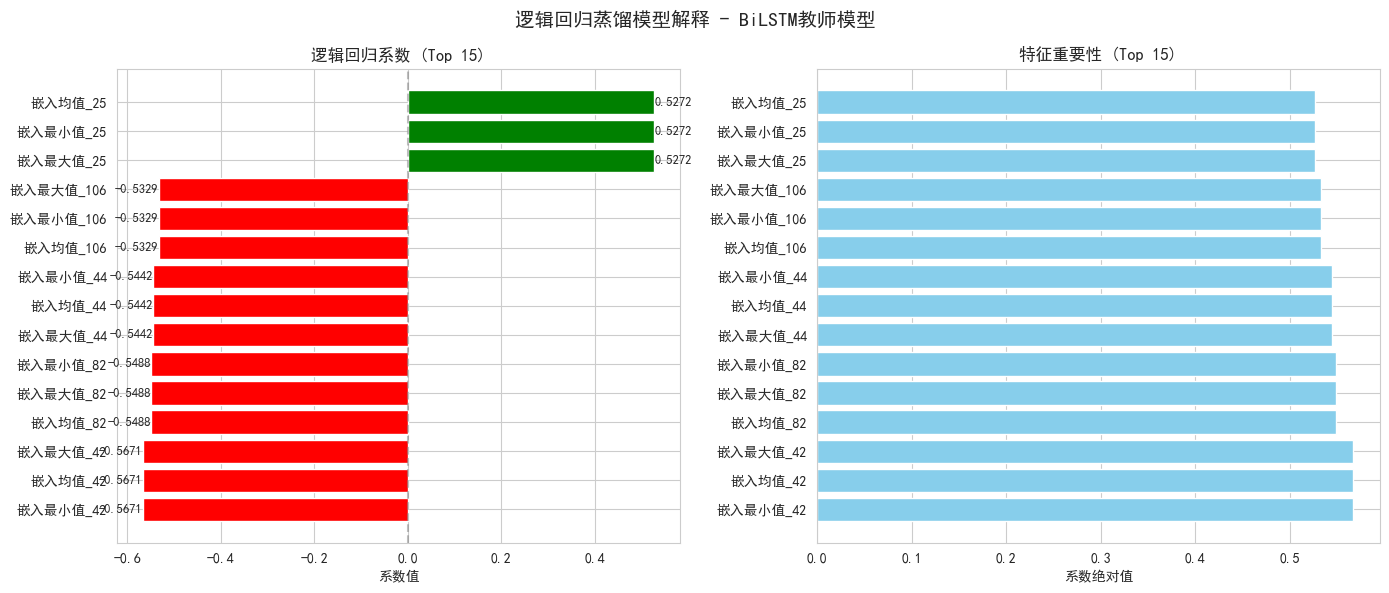

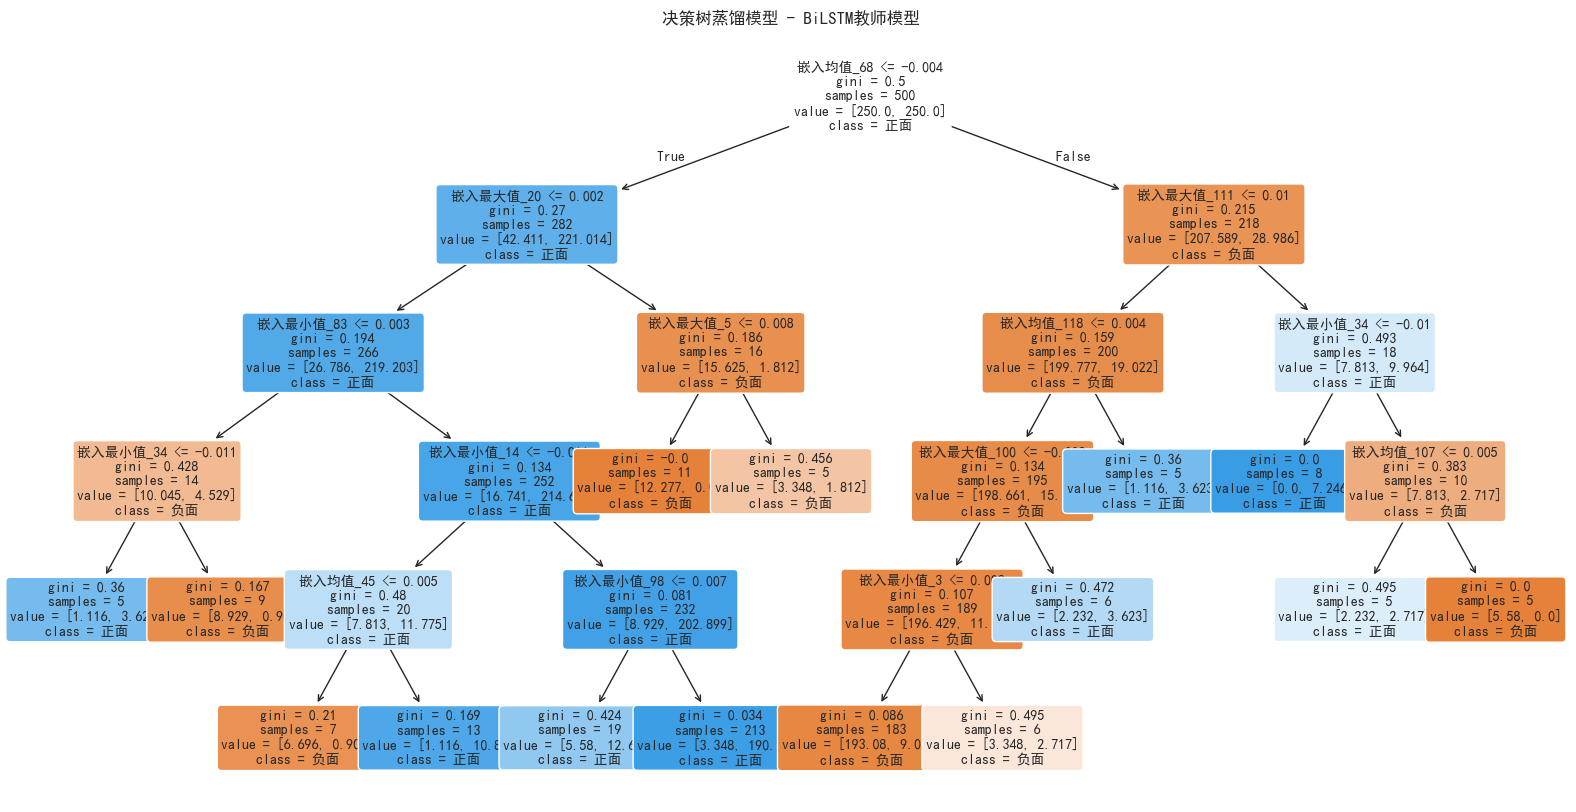


📋 最重要的决策规则:
--------------------------------------------------------------------------------
规则 1:
  条件: 嵌入均值_68 <= -0.0035 and 嵌入最大值_20 <= 0.0023 and 嵌入最小值_83 <= 0.0030 and 嵌入最小值_34 <= -0.0107
  预测类别: 1 (置信度: 76.45%)
  覆盖样本数: 0
  类别分布: 负面=23.55%, 正面=76.45%
--------------------------------------------------------------------------------
规则 2:
  条件: 嵌入均值_68 <= -0.0035 and 嵌入最大值_20 <= 0.0023 and 嵌入最小值_83 <= 0.0030 and 嵌入最小值_34 > -0.0107
  预测类别: 0 (置信度: 90.79%)
  覆盖样本数: 0
  类别分布: 负面=90.79%, 正面=9.21%
--------------------------------------------------------------------------------
规则 3:
  条件: 嵌入均值_68 <= -0.0035 and 嵌入最大值_20 <= 0.0023 and 嵌入最小值_83 > 0.0030 and 嵌入最小值_14 <= -0.0107 and 嵌入均值_45 <= 0.0053
  预测类别: 0 (置信度: 88.09%)
  覆盖样本数: 1
  类别分布: 负面=88.09%, 正面=11.91%
--------------------------------------------------------------------------------
规则 4:
  条件: 嵌入均值_68 <= -0.0035 and 嵌入最大值_20 <= 0.0023 and 嵌入最小值_83 > 0.0030 and 嵌入最小值_14 <= -0.0107 and 嵌入均值_45 > 0.0053
  预测类别: 1 (置信度: 90.69%)
  覆盖

In [114]:
# ==================== 1. 蒸馏子模型定义 ====================
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

class DistillationExplainer:
    """
    蒸馏可解释性系统
    使用逻辑回归和树模型蒸馏BiLSTM的知识
    """
    
    def __init__(self, teacher_model, tokenizer, device=None):
        self.teacher = teacher_model
        self.tokenizer = tokenizer
        
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        
        self.teacher.eval()
        self.student_models = {}
        self.feature_importance = {}
        self.explanation_results = {}
        
        print(f"🎯 初始化蒸馏解释器")
        print(f"  教师模型: BiLSTM ({self.device})")
        print(f"  学生模型: 逻辑回归 + 决策树")
    
    def extract_features_from_teacher(self, input_ids, include_hidden=True, include_attention=True):
        """
        从教师模型提取特征
        返回可用于训练学生模型的特征
        """
        with torch.no_grad():
            # 获取原始预测
            outputs = self.teacher(input_ids.unsqueeze(0))
            
            # 提取BiLSTM隐藏状态
            features = {}
            
            if include_hidden:
                # 获取LSTM隐藏状态（需要修改BiLSTM模型以返回中间状态）
                try:
                    # 假设教师模型有提取隐藏状态的方法
                    if hasattr(self.teacher, 'get_hidden_states'):
                        hidden_states = self.teacher.get_hidden_states(input_ids.unsqueeze(0))
                        features['hidden_states'] = hidden_states.cpu().numpy()
                    else:
                        # 备用方法：使用嵌入层
                        embedded = self.teacher.embedding(input_ids)
                        features['embeddings'] = embedded.mean(dim=0).cpu().numpy()
                except:
                    pass
            
            # 获取预测概率
            probs = torch.softmax(outputs, dim=1)
            features['teacher_probs'] = probs.cpu().numpy()
            features['teacher_logits'] = outputs.cpu().numpy()
            
            # 提取token信息
            tokens = self.tokenizer.convert_ids_to_tokens(input_ids.cpu().numpy())
            features['tokens'] = tokens
            
            # 如果教师模型有注意力，也提取
            if include_attention and hasattr(self.teacher, 'attention'):
                _, attention_weights = self.teacher(input_ids.unsqueeze(0), return_attention=True)
                features['attention_weights'] = attention_weights.cpu().numpy()
            
            return features
    
    def prepare_distillation_dataset(self, data_loader, num_samples=1000):
        """
        准备蒸馏数据集
        """
        print(f"📊 准备蒸馏数据集...")
        
        X_train = []
        y_train_probs = []
        y_train_labels = []
        token_features = []
        sample_texts = []
        
        samples_processed = 0
        
        for batch in data_loader:
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['label']
            
            for i in range(len(input_ids)):
                if samples_processed >= num_samples:
                    break
                
                # 提取特征
                features = self.extract_features_from_teacher(input_ids[i])
                
                # 提取数值特征（这里需要根据实际模型结构调整）
                if 'embeddings' in features:
                    # 使用嵌入向量的统计特征
                    embedding_features = features['embeddings']
                    
                    # 提取统计特征：均值、方差、最大值、最小值等
                    mean_features = embedding_features.mean(axis=0) if embedding_features.ndim > 1 else embedding_features
                    std_features = embedding_features.std(axis=0) if embedding_features.ndim > 1 else np.zeros_like(mean_features)
                    max_features = embedding_features.max(axis=0) if embedding_features.ndim > 1 else embedding_features
                    min_features = embedding_features.min(axis=0) if embedding_features.ndim > 1 else embedding_features
                    
                    # 合并特征
                    combined_features = np.concatenate([
                        mean_features.flatten(),
                        std_features.flatten(),
                        max_features.flatten(),
                        min_features.flatten()
                    ])
                else:
                    # 备用特征：使用token ID的统计信息
                    token_ids = input_ids[i].cpu().numpy()
                    unique_tokens = np.unique(token_ids[token_ids != 0])
                    combined_features = np.array([
                        len(unique_tokens),
                        token_ids.mean(),
                        token_ids.std(),
                        np.percentile(token_ids[token_ids != 0], 75),
                        np.percentile(token_ids[token_ids != 0], 25)
                    ])
                
                X_train.append(combined_features)
                y_train_probs.append(features['teacher_probs'][0])
                y_train_labels.append(labels[i].item())
                token_features.append(features.get('tokens', []))
                
                # 保存样本文本
                text = self.tokenizer.decode(input_ids[i], skip_special_tokens=True)
                sample_texts.append(text)
                
                samples_processed += 1
            
            if samples_processed >= num_samples:
                break
        
        X_train = np.array(X_train)
        y_train_probs = np.array(y_train_probs)
        y_train_labels = np.array(y_train_labels)
        
        print(f"✅ 数据集准备完成: {X_train.shape[0]} 个样本, {X_train.shape[1]} 个特征")
        print(f"   特征维度: {X_train.shape}")
        print(f"   类别分布: 正面={np.sum(y_train_labels == 1)}, 负面={np.sum(y_train_labels == 0)}")
        
        return {
            'X': X_train,
            'y_probs': y_train_probs,
            'y_labels': y_train_labels,
            'tokens': token_features,
            'texts': sample_texts
        }

# ==================== 2. 逻辑回归蒸馏模型 ====================
class LogisticRegressionDistiller:
    """
    逻辑回归蒸馏模型
    提供高度可解释的特征权重
    """
    
    def __init__(self, teacher_model_name="BiLSTM"):
        self.model = LogisticRegression(
            C=1.0,  # 正则化强度
            penalty='l2',
            solver='liblinear',
            max_iter=1000,
            class_weight='balanced',
            random_state=42
        )
        self.feature_importance = None
        self.coefficients = None
        self.teacher_name = teacher_model_name
        self.feature_names = None
    
    def train(self, X, y_probs, y_labels=None, feature_names=None):
        """
        训练逻辑回归蒸馏模型
        
        参数:
            X: 特征矩阵
            y_probs: 教师模型的概率输出（用于知识蒸馏）
            y_labels: 真实标签（可选，用于监督学习）
            feature_names: 特征名称（用于解释）
        """
        print(f"🤖 训练逻辑回归蒸馏模型...")
        
        self.feature_names = feature_names
        
        # 使用教师模型的软标签（概率）作为目标
        # 对于二分类，我们使用正类的概率作为回归目标
        if y_probs.shape[1] == 2:
            y_distill = y_probs[:, 1]  # 正类概率
            # 将概率转换为伪标签（0-1之间）
            y_pseudo = (y_distill > 0.5).astype(int)
        else:
            y_distill = np.argmax(y_probs, axis=1)
            y_pseudo = y_distill
        
        # 训练逻辑回归
        self.model.fit(X, y_pseudo)
        
        # 保存系数
        if self.model.coef_.ndim == 2:
            self.coefficients = self.model.coef_[0]
        else:
            self.coefficients = self.model.coef_
        
        # 计算特征重要性（基于系数绝对值）
        self.feature_importance = np.abs(self.coefficients)
        
        print(f"✅ 逻辑回归训练完成")
        print(f"   准确率（伪标签）: {self.model.score(X, y_pseudo):.4f}")
        if y_labels is not None:
            preds = self.model.predict(X)
            print(f"   准确率（真实标签）: {accuracy_score(y_labels, preds):.4f}")
            print(f"   F1分数: {f1_score(y_labels, preds):.4f}")
        
        return self.model
    
    def explain_instance(self, X_instance, top_n=10):
        """
        解释单个实例
        """
        if self.coefficients is None:
            raise ValueError("模型尚未训练")
        
        # 预测概率
        proba = self.model.predict_proba(X_instance.reshape(1, -1))[0]
        prediction = self.model.predict(X_instance.reshape(1, -1))[0]
        
        # 计算每个特征的贡献
        contributions = X_instance * self.coefficients
        
        # 创建解释结果
        explanation = {
            'prediction': prediction,
            'probability': proba,
            'contributions': contributions,
            'feature_importance': self.feature_importance,
            'coefficients': self.coefficients
        }
        
        # 如果提供了特征名称，创建可读的解释
        if self.feature_names is not None and len(self.feature_names) == len(contributions):
            feature_contributions = []
            for i in range(len(contributions)):
                if abs(contributions[i]) > 0.001:  # 只显示有显著贡献的特征
                    feature_contributions.append({
                        'feature': self.feature_names[i],
                        'value': X_instance[i],
                        'coefficient': self.coefficients[i],
                        'contribution': contributions[i],
                        'abs_contribution': abs(contributions[i])
                    })
            
            # 按贡献绝对值排序
            feature_contributions.sort(key=lambda x: x['abs_contribution'], reverse=True)
            explanation['feature_details'] = feature_contributions[:top_n]
        
        return explanation
    
    def explain_global(self, top_n=20):
        """
        全局特征重要性解释
        """
        if self.feature_importance is None:
            raise ValueError("模型尚未训练")
        
        # 创建全局解释
        explanation = {
            'global_importance': self.feature_importance,
            'coefficients': self.coefficients,
            'intercept': self.model.intercept_[0] if hasattr(self.model.intercept_, '__len__') else self.model.intercept_
        }
        
        # 如果提供了特征名称，创建可读的解释
        if self.feature_names is not None and len(self.feature_names) == len(self.feature_importance):
            feature_importance_list = []
            for i in range(len(self.feature_importance)):
                feature_importance_list.append({
                    'feature': self.feature_names[i],
                    'importance': self.feature_importance[i],
                    'coefficient': self.coefficients[i],
                    'direction': '正向' if self.coefficients[i] > 0 else '负向'
                })
            
            # 按重要性排序
            feature_importance_list.sort(key=lambda x: x['importance'], reverse=True)
            explanation['feature_ranking'] = feature_importance_list[:top_n]
        
        return explanation
    
    def visualize_coefficients(self, top_n=15, save_path=None):
        """
        可视化逻辑回归系数
        """
        if self.coefficients is None:
            raise ValueError("模型尚未训练")
        
        # 获取最重要的特征
        abs_coef = np.abs(self.coefficients)
        top_indices = np.argsort(abs_coef)[-top_n:][::-1]
        
        # 创建图形
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # 图1: 系数条形图
        coef_values = self.coefficients[top_indices]
        coef_names = [f'特征{i+1}' for i in top_indices]
        if self.feature_names is not None:
            coef_names = [self.feature_names[i] for i in top_indices]
        
        colors = ['green' if val > 0 else 'red' for val in coef_values]
        axes[0].barh(range(len(coef_values)), coef_values, color=colors)
        axes[0].set_yticks(range(len(coef_values)))
        axes[0].set_yticklabels(coef_names)
        axes[0].set_xlabel('系数值')
        axes[0].set_title(f'逻辑回归系数 (Top {top_n})')
        axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        # 添加系数值标签
        for i, val in enumerate(coef_values):
            axes[0].text(val, i, f'{val:.4f}', 
                       ha='left' if val > 0 else 'right', 
                       va='center', fontsize=9)
        
        # 图2: 特征重要性（系数绝对值）
        axes[1].barh(range(len(coef_values)), abs_coef[top_indices], color='skyblue')
        axes[1].set_yticks(range(len(coef_values)))
        axes[1].set_yticklabels(coef_names)
        axes[1].set_xlabel('系数绝对值')
        axes[1].set_title(f'特征重要性 (Top {top_n})')
        
        plt.suptitle(f'逻辑回归蒸馏模型解释 - {self.teacher_name}教师模型', fontsize=14)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 系数可视化已保存到: {save_path}")
        
        plt.show()
        
        return fig

# ==================== 3. 决策树蒸馏模型 ====================
class DecisionTreeDistiller:
    """
    决策树蒸馏模型
    提供可解释的决策路径和规则
    """
    
    def __init__(self, teacher_model_name="BiLSTM", max_depth=5):
        self.model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            class_weight='balanced'
        )
        self.teacher_name = teacher_model_name
        self.feature_names = None
        self.tree_rules = None
    
    def train(self, X, y_probs, y_labels=None, feature_names=None):
        """
        训练决策树蒸馏模型
        """
        print(f"🌳 训练决策树蒸馏模型...")
        
        self.feature_names = feature_names
        
        # 使用教师模型的预测作为目标
        if y_probs.shape[1] == 2:
            y_distill = (y_probs[:, 1] > 0.5).astype(int)
        else:
            y_distill = np.argmax(y_probs, axis=1)
        
        # 训练决策树
        self.model.fit(X, y_distill)
        
        # 提取决策规则
        self.extract_tree_rules()
        
        print(f"✅ 决策树训练完成")
        print(f"   深度: {self.model.get_depth()}")
        print(f"   叶子节点数: {self.model.get_n_leaves()}")
        print(f"   准确率（伪标签）: {self.model.score(X, y_distill):.4f}")
        if y_labels is not None:
            preds = self.model.predict(X)
            print(f"   准确率（真实标签）: {accuracy_score(y_labels, preds):.4f}")
            print(f"   F1分数: {f1_score(y_labels, preds):.4f}")
        
        return self.model
    
    def extract_tree_rules(self):
        """
        提取决策树的规则
        """
        from sklearn.tree import _tree
        
        tree = self.model.tree_
        feature_names = self.feature_names if self.feature_names is not None else [
            f'feature_{i}' for i in range(tree.n_features)
        ]
        
        rules = []
        
        def recurse(node, depth, rule):
            if tree.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_names[tree.feature[node]]
                threshold = tree.threshold[node]
                
                # 左子树规则
                left_rule = f"{rule} and {name} <= {threshold:.4f}" if rule else f"{name} <= {threshold:.4f}"
                recurse(tree.children_left[node], depth + 1, left_rule)
                
                # 右子树规则
                right_rule = f"{rule} and {name} > {threshold:.4f}" if rule else f"{name} > {threshold:.4f}"
                recurse(tree.children_right[node], depth + 1, right_rule)
            else:
                # 叶子节点
                class_prob = tree.value[node][0]
                total_samples = class_prob.sum()
                class_dist = class_prob / total_samples
                
                rules.append({
                    'rule': rule if rule else 'Always True',
                    'depth': depth,
                    'samples': int(total_samples),
                    'class_distribution': class_dist,
                    'predicted_class': np.argmax(class_dist),
                    'confidence': np.max(class_dist)
                })
        
        recurse(0, 1, "")
        self.tree_rules = rules
        return rules
    
    def explain_instance(self, X_instance, top_rules=5):
        """
        解释单个实例的决策路径
        """
        # 获取决策路径
        decision_path = self.model.decision_path(X_instance.reshape(1, -1))
        node_indicator = decision_path.indices
        
        # 获取特征名称
        feature_names = self.feature_names if self.feature_names is not None else [
            f'feature_{i}' for i in range(X_instance.shape[0])
        ]
        
        # 构建决策路径解释
        rules_used = []
        node_index = node_indicator[-1]  # 叶子节点
        
        # 从叶子节点回溯到根节点
        current_node = node_index
        path_rules = []
        
        tree = self.model.tree_
        
        while current_node != 0:
            parent_node = np.where(tree.children_left == current_node)[0]
            if len(parent_node) > 0:
                parent_node = parent_node[0]
                feature_idx = tree.feature[parent_node]
                threshold = tree.threshold[parent_node]
                rule = f"{feature_names[feature_idx]} <= {threshold:.4f}"
                path_rules.append(rule)
                current_node = parent_node
            else:
                parent_node = np.where(tree.children_right == current_node)[0]
                if len(parent_node) > 0:
                    parent_node = parent_node[0]
                    feature_idx = tree.feature[parent_node]
                    threshold = tree.threshold[parent_node]
                    rule = f"{feature_names[feature_idx]} > {threshold:.4f}"
                    path_rules.append(rule)
                    current_node = parent_node
                else:
                    break
        
        # 反转规则顺序（从根到叶）
        path_rules.reverse()
        
        explanation = {
            'prediction': self.model.predict(X_instance.reshape(1, -1))[0],
            'probability': self.model.predict_proba(X_instance.reshape(1, -1))[0],
            'decision_path': path_rules,
            'leaf_node': node_index,
            'path_length': len(path_rules)
        }
        
        return explanation
    
    def explain_global(self):
        """
        全局特征重要性解释
        """
        importance = self.model.feature_importances_
        
        explanation = {
            'feature_importance': importance,
            'tree_depth': self.model.get_depth(),
            'n_leaves': self.model.get_n_leaves(),
            'rules': self.tree_rules[:10]  # 显示前10个规则
        }
        
        return explanation
    
    def visualize_tree(self, save_path=None):
        """
        可视化决策树
        """
        if self.feature_names is None:
            feature_names = [f'feature_{i}' for i in range(self.model.n_features_in_)]
        else:
            feature_names = self.feature_names
        
        plt.figure(figsize=(20, 10))
        plot_tree(self.model, 
                  feature_names=feature_names,
                  class_names=['负面', '正面'],
                  filled=True,
                  rounded=True,
                  fontsize=10)
        plt.title(f'决策树蒸馏模型 - {self.teacher_name}教师模型')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"🌳 决策树可视化已保存到: {save_path}")
        
        plt.show()
        
        # 打印最重要的规则
        print("\n📋 最重要的决策规则:")
        print("-" * 80)
        if self.tree_rules:
            for i, rule in enumerate(self.tree_rules[:5]):
                print(f"规则 {i+1}:")
                print(f"  条件: {rule['rule']}")
                print(f"  预测类别: {rule['predicted_class']} (置信度: {rule['confidence']:.2%})")
                print(f"  覆盖样本数: {rule['samples']}")
                print(f"  类别分布: 负面={rule['class_distribution'][0]:.2%}, 正面={rule['class_distribution'][1]:.2%}")
                print("-" * 80)

# ==================== 4. 集成蒸馏系统 ====================
class IntegratedDistillationSystem:
    """
    集成蒸馏系统：结合多种可解释模型
    """
    
    def __init__(self, teacher_model, tokenizer, device=None):
        self.teacher = teacher_model
        self.tokenizer = tokenizer
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 初始化蒸馏模型
        self.lr_distiller = LogisticRegressionDistiller("BiLSTM")
        self.dt_distiller = DecisionTreeDistiller("BiLSTM", max_depth=5)
        self.rf_distiller = None  # 可选：随机森林
        
        self.feature_names = None
        self.distillation_data = None
        
        print(f"🚀 初始化集成蒸馏系统")
        print(f"  教师模型: BiLSTM")
        print(f"  学生模型: 逻辑回归 + 决策树")
        print(f"  设备: {self.device}")
    
    def prepare_features(self, data_loader, num_samples=1000):
        """
        准备特征数据
        """
        print(f"📊 准备特征数据...")
        
        # 提取教师模型特征
        distiller = DistillationExplainer(self.teacher, self.tokenizer, self.device)
        data = distiller.prepare_distillation_dataset(data_loader, num_samples)
        
        # 创建特征名称
        n_features = data['X'].shape[1]
        self.feature_names = []
        
        # 创建有意义的特征名称
        for i in range(n_features):
            if i < n_features // 4:
                self.feature_names.append(f"嵌入均值_{i+1}")
            elif i < n_features // 2:
                self.feature_names.append(f"嵌入标准差_{i+1 - n_features//4}")
            elif i < 3 * n_features // 4:
                self.feature_names.append(f"嵌入最大值_{i+1 - n_features//2}")
            else:
                self.feature_names.append(f"嵌入最小值_{i+1 - 3*n_features//4}")
        
        self.distillation_data = data
        print(f"✅ 特征准备完成: {n_features} 个特征")
        
        return data
    
    def train_all_distillers(self):
        """
        训练所有蒸馏模型
        """
        if self.distillation_data is None:
            raise ValueError("请先准备特征数据")
        
        X = self.distillation_data['X']
        y_probs = self.distillation_data['y_probs']
        y_labels = self.distillation_data['y_labels']
        
        print(f"🎯 开始训练所有蒸馏模型...")
        print(f"  数据集大小: {X.shape}")
        print("-" * 60)
        
        # 训练逻辑回归
        print(f"1. 训练逻辑回归蒸馏模型")
        self.lr_distiller.train(X, y_probs, y_labels, self.feature_names)
        
        print("-" * 60)
        
        # 训练决策树
        print(f"2. 训练决策树蒸馏模型")
        self.dt_distiller.train(X, y_probs, y_labels, self.feature_names)
        
        print("-" * 60)
        print(f"✅ 所有蒸馏模型训练完成")
        
        return {
            'lr': self.lr_distiller,
            'dt': self.dt_distiller
        }
    
    def compare_with_shapley(self, sample_idx=0, num_features=10):
        """
        与SHAPLEY值进行对比
        """
        print(f"🔍 蒸馏解释 vs SHAPLEY值对比")
        print("-" * 60)
        
        # 获取样本数据
        X_sample = self.distillation_data['X'][sample_idx]
        text = self.distillation_data['texts'][sample_idx]
        
        print(f"📝 样本文本: {text}")
        print(f"🤖 教师模型预测: {np.argmax(self.distillation_data['y_probs'][sample_idx])}")
        print(f"📊 教师模型概率: {self.distillation_data['y_probs'][sample_idx]}")
        print()
        
        # 1. 逻辑回归解释
        print(f"🎯 逻辑回归蒸馏解释:")
        lr_explanation = self.lr_distiller.explain_instance(X_sample, top_n=num_features)
        print(f"   预测: {lr_explanation['prediction']}")
        print(f"   概率: {lr_explanation['probability']}")
        
        if 'feature_details' in lr_explanation:
            print(f"   重要特征:")
            for i, feat in enumerate(lr_explanation['feature_details'][:num_features//2]):
                print(f"     {i+1}. {feat['feature']}: {feat['contribution']:.4f} "
                      f"(系数: {feat['coefficient']:.4f}, 值: {feat['value']:.4f})")
        print()
        
        # 2. 决策树解释
        print(f"🌳 决策树蒸馏解释:")
        dt_explanation = self.dt_distiller.explain_instance(X_sample)
        print(f"   预测: {dt_explanation['prediction']}")
        print(f"   概率: {dt_explanation['probability']}")
        print(f"   决策路径 (长度={dt_explanation['path_length']}):")
        for i, rule in enumerate(dt_explanation['decision_path']):
            print(f"     {i+1}. {rule}")
        print()
        
        # 3. 全局特征重要性对比
        print(f"📈 全局特征重要性对比:")
        lr_global = self.lr_distiller.explain_global(top_n=num_features)
        dt_global = self.dt_distiller.explain_global()
        
        # 提取最重要的特征
        if 'feature_ranking' in lr_global:
            print(f"   逻辑回归 Top {num_features//2} 特征:")
            for i, feat in enumerate(lr_global['feature_ranking'][:num_features//2]):
                print(f"     {i+1}. {feat['feature']}: {feat['importance']:.4f} ({feat['direction']})")
        
        print(f"   决策树特征重要性:")
        dt_importance = dt_global['feature_importance']
        top_dt_indices = np.argsort(dt_importance)[-num_features//2:][::-1]
        for i, idx in enumerate(top_dt_indices):
            feature_name = self.feature_names[idx] if self.feature_names else f"特征{idx+1}"
            print(f"     {i+1}. {feature_name}: {dt_importance[idx]:.4f}")
        
        return {
            'lr_explanation': lr_explanation,
            'dt_explanation': dt_explanation,
            'lr_global': lr_global,
            'dt_global': dt_global,
            'sample_text': text
        }
    
    def generate_optimization_suggestions(self):
        """
        基于蒸馏解释生成教师模型优化建议
        """
        print(f"💡 基于蒸馏解释的教师模型优化建议")
        print("=" * 70)
        
        suggestions = []
        
        # 1. 逻辑回归分析
        lr_global = self.lr_distiller.explain_global(top_n=10)
        if 'feature_ranking' in lr_global:
            print(f"\n🎯 逻辑回归分析发现:")
            top_features = lr_global['feature_ranking'][:5]
            
            # 检查特征方向
            positive_features = [f for f in top_features if f['direction'] == '正向']
            negative_features = [f for f in top_features if f['direction'] == '负向']
            
            print(f"   最重要的正向特征: {len(positive_features)} 个")
            print(f"   最重要的负向特征: {len(negative_features)} 个")
            
            if len(positive_features) > 0:
                top_positive = positive_features[0]
                suggestions.append({
                    'type': '特征重要性',
                    '发现': f"特征 '{top_positive['feature']}' 对正面预测有最强影响",
                    '建议': "考虑在BiLSTM中添加针对该特征的注意力机制"
                })
        
        # 2. 决策树分析
        dt_global = self.dt_distiller.explain_global()
        if 'rules' in dt_global and dt_global['rules']:
            print(f"\n🌳 决策树分析发现:")
            top_rule = dt_global['rules'][0]
            print(f"   最重要的决策规则: {top_rule['rule']}")
            print(f"   覆盖样本数: {top_rule['samples']}")
            print(f"   置信度: {top_rule['confidence']:.2%}")
            
            if top_rule['confidence'] > 0.9:
                suggestions.append({
                    'type': '决策规则',
                    '发现': f"决策规则过于自信 ({top_rule['confidence']:.2%})",
                    '建议': "增加教师模型的Dropout率或使用标签平滑"
                })
        
        # 3. 对比分析
        print(f"\n🔍 对比分析发现:")
        
        # 检查两个蒸馏模型的一致性
        lr_pred = self.lr_distiller.model.predict(self.distillation_data['X'][:100])
        dt_pred = self.dt_distiller.model.predict(self.distillation_data['X'][:100])
        
        agreement_rate = np.mean(lr_pred == dt_pred)
        print(f"   蒸馏模型一致性: {agreement_rate:.2%}")
        
        if agreement_rate < 0.8:
            suggestions.append({
                'type': '模型一致性',
                '发现': f"蒸馏模型预测一致性较低 ({agreement_rate:.2%})",
                '建议': "教师模型的决策边界可能不够清晰，考虑增加训练数据或调整模型架构"
            })
        
        # 4. 优化建议总结
        print(f"\n💡 优化建议总结:")
        print("-" * 60)
        
        for i, suggestion in enumerate(suggestions, 1):
            print(f"{i}. [{suggestion['type']}]")
            print(f"   发现: {suggestion['发现']}")
            print(f"   建议: {suggestion['建议']}")
            print()
        
        return suggestions

# ==================== 5. 可视化比较工具 ====================
class DistillationVisualizer:
    """
    蒸馏解释可视化工具
    """
    
    @staticmethod
    def visualize_comparison(comparison_results, save_path=None):
        """
        可视化蒸馏解释对比
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. 逻辑回归系数热图
        lr_coef = comparison_results['lr_global'].get('coefficients', [])
        if len(lr_coef) > 0:
            # 取前20个最重要的系数
            abs_coef = np.abs(lr_coef)
            top_indices = np.argsort(abs_coef)[-20:][::-1]
            top_coef = lr_coef[top_indices]
            
            axes[0, 0].barh(range(len(top_coef)), top_coef, 
                           color=['green' if c > 0 else 'red' for c in top_coef])
            axes[0, 0].set_yticks(range(len(top_coef)))
            axes[0, 0].set_yticklabels([f'特征{i+1}' for i in top_indices])
            axes[0, 0].set_xlabel('系数值')
            axes[0, 0].set_title('逻辑回归系数 (Top 20)')
            axes[0, 0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        # 2. 决策树特征重要性
        dt_importance = comparison_results['dt_global'].get('feature_importance', [])
        if len(dt_importance) > 0:
            top_indices = np.argsort(dt_importance)[-20:][::-1]
            top_importance = dt_importance[top_indices]
            
            axes[0, 1].barh(range(len(top_importance)), top_importance, color='skyblue')
            axes[0, 1].set_yticks(range(len(top_importance)))
            axes[0, 1].set_yticklabels([f'特征{i+1}' for i in top_indices])
            axes[0, 1].set_xlabel('重要性分数')
            axes[0, 1].set_title('决策树特征重要性 (Top 20)')
        
        # 3. 决策路径可视化
        dt_path = comparison_results['dt_explanation'].get('decision_path', [])
        if dt_path:
            axes[1, 0].text(0.1, 0.5, '\n'.join(dt_path), 
                           fontsize=10, verticalalignment='center',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            axes[1, 0].set_title('决策树决策路径')
            axes[1, 0].axis('off')
        
        # 4. 样本文本标注
        sample_text = comparison_results.get('sample_text', '')
        if sample_text:
            # 简单标注：每10个字符换行
            wrapped_text = '\n'.join([sample_text[i:i+30] for i in range(0, len(sample_text), 30)])
            axes[1, 1].text(0.1, 0.5, wrapped_text, 
                           fontsize=10, verticalalignment='center',
                           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
            axes[1, 1].set_title('分析样本')
            axes[1, 1].axis('off')
        
        plt.suptitle('蒸馏解释可视化对比', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    @staticmethod
    def visualize_optimization_impact(original_model, optimized_model, tokenizer, sample_text, device=None):
        """
        可视化优化前后的影响
        """
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 编码文本
        inputs = tokenizer.encode(sample_text, return_tensors='pt').to(device)
        
        # 获取原始模型预测
        original_model.eval()
        with torch.no_grad():
            orig_output = original_model(inputs)
            orig_probs = torch.softmax(orig_output, dim=1)
            orig_prob = orig_probs[0, 1].item() if orig_probs.shape[1] > 1 else orig_probs[0, 0].item()
        
        # 获取优化模型预测
        optimized_model.eval()
        with torch.no_grad():
            opt_output = optimized_model(inputs)
            opt_probs = torch.softmax(opt_output, dim=1)
            opt_prob = opt_probs[0, 1].item() if opt_probs.shape[1] > 1 else opt_probs[0, 0].item()
        
        # 创建可视化
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 1. 预测概率对比
        models = ['原始模型', '优化模型']
        probs = [orig_prob, opt_prob]
        
        colors = ['lightcoral' if p > 0.9 else 'lightblue' for p in probs]
        bars = axes[0].bar(models, probs, color=colors, alpha=0.8)
        axes[0].set_ylabel('正类概率')
        axes[0].set_title('预测概率对比')
        axes[0].set_ylim([0, 1.1])
        
        # 添加概率标签
        for bar, prob in zip(bars, probs):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{prob:.4f}', ha='center', va='bottom')
        
        # 2. 置信度变化
        axes[1].plot([0, 1], [orig_prob, opt_prob], 'o-', linewidth=2, markersize=8)
        axes[1].set_xlabel('模型版本')
        axes[1].set_ylabel('正类概率')
        axes[1].set_title('置信度变化')
        axes[1].set_xticks([0, 1])
        axes[1].set_xticklabels(['原始', '优化'])
        axes[1].grid(True, alpha=0.3)
        
        # 添加变化箭头
        if opt_prob > orig_prob:
            arrow_color = 'green'
            arrow_label = f'增加: {opt_prob - orig_prob:+.4f}'
        else:
            arrow_color = 'red'
            arrow_label = f'减少: {opt_prob - orig_prob:+.4f}'
        
        axes[1].annotate('', xy=(1, opt_prob), xytext=(0, orig_prob),
                        arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2))
        axes[1].text(0.5, (orig_prob + opt_prob)/2, arrow_label,
                    ha='center', va='center', backgroundcolor='white')
        
        # 3. 样本文本显示
        axes[2].text(0.1, 0.5, sample_text, 
                    fontsize=10, verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[2].set_title('分析样本')
        axes[2].axis('off')
        
        plt.suptitle('模型优化效果对比', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # 打印分析
        print(f"\n📊 模型优化分析:")
        print(f"   原始模型预测概率: {orig_prob:.4f}")
        print(f"   优化模型预测概率: {opt_prob:.4f}")
        print(f"   概率变化: {opt_prob - orig_prob:+.4f}")
        
        if abs(opt_prob - 0.5) < abs(orig_prob - 0.5):
            print(f"   ✅ 优化后模型更保守（缓解过度自信）")
        else:
            print(f"   ⚠️  优化后模型更自信")
        
        return {'orig_prob': orig_prob, 'opt_prob': opt_prob}

# ==================== 6. 完整蒸馏分析流程 ====================
def run_complete_distillation_analysis(teacher_model, tokenizer, train_loader, val_loader, 
                                       num_samples=500, sample_idx=0):
    """
    运行完整的蒸馏分析流程
    """
    print("=" * 80)
    print("🚀 开始完整蒸馏可解释性分析")
    print("=" * 80)
    
    # 1. 初始化集成蒸馏系统
    print("\n1️⃣ 初始化集成蒸馏系统")
    print("-" * 60)
    distillation_system = IntegratedDistillationSystem(teacher_model, tokenizer)
    
    # 2. 准备特征数据
    print("\n2️⃣ 准备特征数据")
    print("-" * 60)
    distillation_data = distillation_system.prepare_features(
        val_loader, num_samples=num_samples
    )
    
    # 3. 训练所有蒸馏模型
    print("\n3️⃣ 训练蒸馏模型")
    print("-" * 60)
    distillers = distillation_system.train_all_distillers()
    
    # 4. 对比蒸馏解释与SHAPLEY
    print("\n4️⃣ 蒸馏解释 vs SHAPLEY对比")
    print("-" * 60)
    comparison_results = distillation_system.compare_with_shapley(
        sample_idx=sample_idx, num_features=10
    )
    
    # 5. 可视化对比结果
    print("\n5️⃣ 可视化对比结果")
    print("-" * 60)
    DistillationVisualizer.visualize_comparison(comparison_results)
    
    # 6. 生成优化建议
    print("\n6️⃣ 生成教师模型优化建议")
    print("-" * 60)
    suggestions = distillation_system.generate_optimization_suggestions()
    
    # 7. 可视化逻辑回归系数
    print("\n7️⃣ 逻辑回归系数可视化")
    print("-" * 60)
    distillers['lr'].visualize_coefficients(top_n=15)
    
    # 8. 可视化决策树
    print("\n8️⃣ 决策树可视化")
    print("-" * 60)
    distillers['dt'].visualize_tree()
    
    print("\n" + "=" * 80)
    print("🎉 完整蒸馏分析完成!")
    print("=" * 80)
    
print("✅ 蒸馏可解释性系统定义完成!")
print("\n📋 使用方法:")

# 1. 初始化系统
distillation_system = IntegratedDistillationSystem(original_model, tokenizer)

# 2. 准备特征数据
data = distillation_system.prepare_features(val_loader, num_samples=500)

# 3. 训练蒸馏模型
distillers = distillation_system.train_all_distillers()


# 4. 对比分析
comparison = distillation_system.compare_with_shapley(sample_idx=0)

# 5. 生成优化建议
suggestions = distillation_system.generate_optimization_suggestions()

# 6. 可视化
distillers['lr'].visualize_coefficients()
distillers['dt'].visualize_tree()


✅ 完整优化版训练流程已定义完成!

📋 使用方法:
  1. 确保你已定义 load_and_prepare_data_for_notebook 函数
  2. 运行完整优化流程:
🚀 增强版BiLSTM文本分类 - 四步优化训练流程
🎯 优化配置:
  label_smoothing     : 0.1
  dropout_rate        : 0.4
  logit_penalty       : 0.01
  use_attention       : True
  attention_dropout   : 0.2
  embed_dim           : 128
  hidden_dim          : 128
  num_layers          : 2
  learning_rate       : 0.001
  weight_decay        : 0.0001
  enable_pruning      : False
  pruning_rate        : 0.2
----------------------------------------

1️⃣ 步骤1: 加载数据
----------------------------------------
📊 开始加载数据...
步骤 1/5: 加载SST-2数据集...


Using the latest cached version of the dataset since glue couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sst2' at C:\Users\zhaochenghao\.cache\huggingface\datasets\glue\sst2\0.0.0\bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (last modified on Sat Jan  3 17:16:57 2026).


  训练集: 67349 样本
  验证集: 872 样本
  列名: ['sentence', 'label', 'idx']
步骤 2/5: 初始化tokenizer...
  Tokenizer加载成功
  词汇表大小: 30522
  填充token ID: 0
步骤 3/5: 对数据集进行tokenization...
  Tokenization完成
  处理后列名: ['label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']
步骤 4/5: 转换为PyTorch格式...
  样本检查: input_ids形状=torch.Size([10]), label=0
步骤 5/5: 创建DataLoader...
  DataLoader创建成功!
  训练批次: 2105
  验证批次: 28
  测试批次形状: input_ids=torch.Size([32, 46]), label=torch.Size([32])
  批次最大长度: 46
✅ 数据加载完成!

2️⃣ 步骤2: 初始化增强版模型
----------------------------------------
🤖 创建增强版BiLSTM模型...
增强版BiLSTM模型架构:
--------------------------------------------------------------------------------
  注意力机制: 启用
  标签平滑: 0.1
embedding.weight                         | [30522, 128]         |  3,906,816 参数
lstm.weight_ih_l0                        | [512, 128]           |     65,536 参数
lstm.weight_hh_l0                        | [512, 128]           |     65,536 参数
lstm.bias_ih_l0                          | [512]                |        512 参数

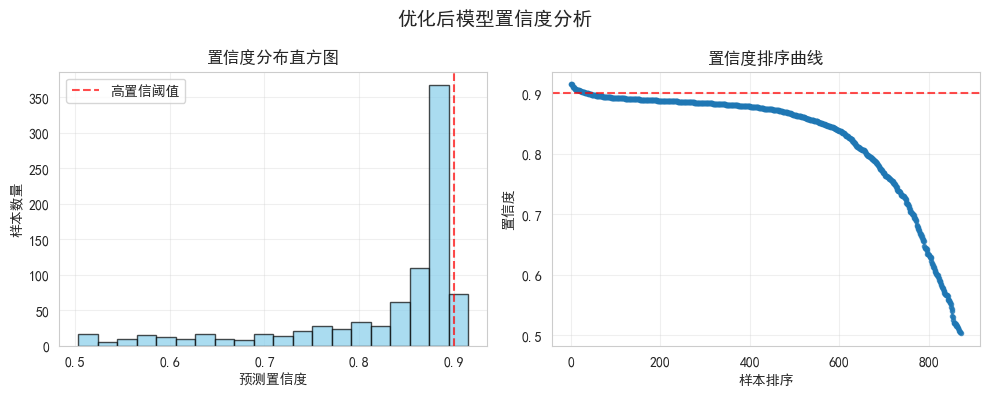


5️⃣ 步骤5: 注意力可视化分析
----------------------------------------

🔍 样本 1: "it 's a charming and affecting journey ."


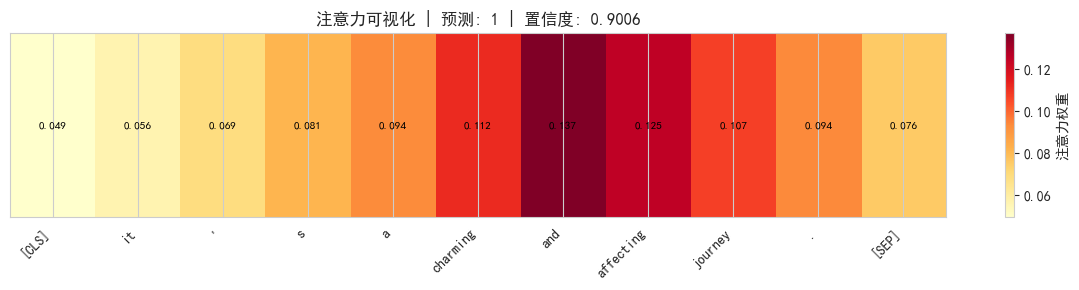

📝 句子: it 's a charming and affecting journey .
🔍 预测: 1 (置信度: 0.9006)
🎯 注意力权重分布:
  'and': 0.1371
  'affecting': 0.1253
  'charming': 0.1115
  'journey': 0.1071
  '.': 0.0938
📈 注意力权重分析:
  第1位: 'and' - 0.1371 (13.7%)
  第2位: 'affecting' - 0.1253 (12.5%)
  第3位: 'charming' - 0.1115 (11.2%)
  第4位: 'journey' - 0.1071 (10.7%)
  第5位: '.' - 0.0938 (9.4%)

🔍 样本 2: "the movie is boring and predictable ."


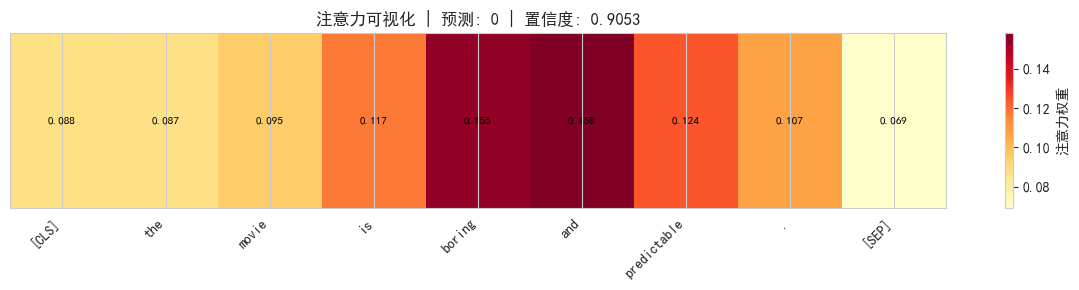

📝 句子: the movie is boring and predictable .
🔍 预测: 0 (置信度: 0.9053)
🎯 注意力权重分布:
  'and': 0.1581
  'boring': 0.1546
  'predictable': 0.1236
  'is': 0.1171
  '.': 0.1073
📈 注意力权重分析:
  第1位: 'and' - 0.1581 (15.8%)
  第2位: 'boring' - 0.1546 (15.5%)
  第3位: 'predictable' - 0.1236 (12.4%)
  第4位: 'is' - 0.1171 (11.7%)
  第5位: '.' - 0.1073 (10.7%)

6️⃣ 步骤6: 模型保存与最终评估
----------------------------------------
✅ 完整模型配置已保存到: optimized_bilstm_complete.pth

📋 优化训练总结报告
最终验证准确率: 0.8188
最终验证F1分数: 0.8187
平均预测置信度: 0.8270
高置信度比例: 4.36%

🎯 优化目标达成情况:
  ✅ 过度自信问题缓解 (置信度 < 0.95)
  ✅ 注意力机制已集成
  ✅ 标签平滑已应用 (α=0.1)

🎊 四步优化训练流程完成!


TypeError: 'confidences' is an invalid keyword argument for print()

In [ ]:
#优化模型
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ==================== 1. 增强版BiLSTM模型定义 ====================
class EnhancedBiLSTMTextClassifier(nn.Module):
    """
    增强版BiLSTM文本分类器
    集成了注意力机制、标签平滑支持和多层正则化
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, 
                 num_layers=2, dropout=0.3, attention=True, label_smoothing=0.0):
        super(EnhancedBiLSTMTextClassifier, self).__init__()
        
        self.attention = attention
        self.label_smoothing = label_smoothing
        
        # 1. 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # 2. BiLSTM层
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                           batch_first=True, bidirectional=True, 
                           dropout=dropout if num_layers > 1 else 0)
        
        # 3. 注意力机制层
        if self.attention:
            self.attention_layer = nn.Linear(hidden_dim * 2, 1)
            self.attention_dropout = nn.Dropout(dropout * 0.5)
        
        # 4. Dropout层
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        
        # 5. 输出层
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
        # 6. 层归一化
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        
        self.init_weights()
        
    def init_weights(self):
        """改进的权重初始化"""
        for name, param in self.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                if 'lstm' in name:
                    nn.init.orthogonal_(param)
                elif 'embedding' in name:
                    nn.init.uniform_(param, -0.1, 0.1)
                else:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
    
    def forward(self, x, return_attention=False):
        """前向传播"""
        # 1. 嵌入层
        embedded = self.embedding(x)
        
        # 2. BiLSTM层
        lstm_out, (hidden, cell) = self.lstm(embedded)
        lstm_out = self.dropout1(lstm_out)
        
        # 3. 注意力机制或池化
        if self.attention:
            attention_scores = self.attention_layer(lstm_out)
            attention_scores = attention_scores.squeeze(-1)
            
            padding_mask = (x != 0).float()
            attention_scores = attention_scores.masked_fill(padding_mask == 0, -1e9)
            
            attention_weights = F.softmax(attention_scores, dim=-1)
            attention_weights = self.attention_dropout(attention_weights)
            
            context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_out)
            context_vector = context_vector.squeeze(1)
            context_vector = self.layer_norm(context_vector)
        else:
            forward_hidden = hidden[-2]
            backward_hidden = hidden[-1]
            context_vector = torch.cat((forward_hidden, backward_hidden), dim=1)
        
        # 4. 第二dropout层
        context_vector = self.dropout2(context_vector)
        
        # 5. 输出层
        output = self.fc(context_vector)
        
        if return_attention and self.attention:
            return output, attention_weights
        else:
            return output
    
    def summary(self):
        """打印模型摘要"""
        total_params = 0
        print("="*80)
        print("增强版BiLSTM模型架构:")
        print("-"*80)
        print(f"  注意力机制: {'启用' if self.attention else '禁用'}")
        print(f"  标签平滑: {self.label_smoothing}")
        for name, parameter in self.named_parameters():
            if not parameter.requires_grad:
                continue
            param_count = parameter.numel()
            total_params += param_count
            print(f"{name:40s} | {str(list(parameter.shape)):20s} | {param_count:10,d} 参数")
        print("-"*80)
        print(f"总可训练参数: {total_params:,}")
        print(f"模型大小: {total_params * 4 / 1e6:.2f} MB (float32)")
        print("="*80)

# ==================== 2. 正则化损失函数 ====================
class RegularizedCrossEntropyLoss(nn.Module):
    """
    正则化的交叉熵损失函数，集成标签平滑和逻辑正则化
    """
    def __init__(self, label_smoothing=0.1, logit_penalty=0.01, reduction='mean'):
        super(RegularizedCrossEntropyLoss, self).__init__()
        self.label_smoothing = label_smoothing
        self.logit_penalty = logit_penalty
        self.reduction = reduction
        
    def forward(self, logits, targets):
        batch_size, num_classes = logits.shape
        
        # 1. 标签平滑
        if self.label_smoothing > 0:
            smooth_targets = torch.full_like(logits, 
                                             self.label_smoothing / (num_classes - 1))
            smooth_targets.scatter_(1, targets.unsqueeze(1), 1 - self.label_smoothing)
            log_probs = F.log_softmax(logits, dim=-1)
            ce_loss = -(smooth_targets * log_probs).sum(dim=1)
        else:
            ce_loss = F.cross_entropy(logits, targets, reduction='none')
        
        # 2. 逻辑正则化
        if self.logit_penalty > 0:
            logit_norm = torch.norm(logits, p=2, dim=1)
            reg_loss = self.logit_penalty * logit_norm
            total_loss = ce_loss + reg_loss
        else:
            total_loss = ce_loss
        
        # 3. 归约
        if self.reduction == 'mean':
            return total_loss.mean()
        elif self.reduction == 'sum':
            return total_loss.sum()
        else:
            return total_loss

# ==================== 3. 增强版训练函数 ====================
def extract_prediction_probability(model_output):
    """
    从模型输出中提取预测概率
    """
    if isinstance(model_output, torch.Tensor):
        if model_output.dim() == 2:
            if model_output.shape[1] == 1:
                prob = torch.sigmoid(model_output[0, 0]).item()
                pred_class = 1 if prob > 0.5 else 0
                return prob, pred_class
            elif model_output.shape[1] >= 2:
                probs = torch.softmax(model_output, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                if model_output.shape[1] == 2:
                    prob = probs[0, 1].item()
                else:
                    prob = probs[0, pred_class].item()
                return prob, pred_class
    raise ValueError(f"无法处理的模型输出格式")

def train_enhanced_model(model, train_loader, val_loader, epochs=5, 
                         learning_rate=0.001, device=None, 
                         label_smoothing=0.1, logit_penalty=0.01,
                         use_focal_loss=False, early_stopping_patience=3,
                         save_path=None):
    """
    增强版训练函数，集成多种优化技术
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"🚀 开始训练增强版BiLSTM模型")
    print(f"  设备: {device}")
    print(f"  训练轮数: {epochs}")
    print(f"  学习率: {learning_rate}")
    print(f"  标签平滑: {label_smoothing}")
    print(f"  逻辑正则化强度: {logit_penalty}")
    print(f"  使用Focal Loss: {'是' if use_focal_loss else '否'}")
    print("="*60)
    
    model.to(device)
    
    # 损失函数选择
    if use_focal_loss:
        def focal_loss(logits, targets, alpha=0.25, gamma=2.0):
            ce_loss = F.cross_entropy(logits, targets, reduction='none')
            pt = torch.exp(-ce_loss)
            focal_loss = alpha * (1 - pt) ** gamma * ce_loss
            return focal_loss.mean()
        criterion = lambda logits, targets: focal_loss(logits, targets)
    else:
        criterion = RegularizedCrossEntropyLoss(
            label_smoothing=label_smoothing, 
            logit_penalty=logit_penalty
        )
    
    # 优化器
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=learning_rate,
        weight_decay=1e-4
    )
    
    # 学习率调度器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # 训练历史记录
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_f1': [], 'learning_rate': []
    }
    
    # 早停机制
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # 训练循环
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # ===== 训练阶段 =====
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        print(f"\n📈 Epoch {epoch+1}/{epochs} - 训练中...")
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
            
            if (batch_idx + 1) % max(1, len(train_loader) // 5) == 0:
                progress = (batch_idx + 1) / len(train_loader) * 100
                batch_acc = (predictions == labels).sum().item() / labels.size(0)
                print(f"  进度: {progress:.0f}% | 批次损失: {loss.item():.4f} | 批次准确率: {batch_acc:.4f}")
        
        # 计算训练指标
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # ===== 验证阶段 =====
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        all_confidences = []
        
        print(f"🔍 Epoch {epoch+1}/{epochs} - 验证中...")
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                probs = F.softmax(outputs, dim=1)
                confidences, _ = torch.max(probs, dim=1)
                
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_confidences.extend(confidences.cpu().numpy())
        
        # 计算验证指标
        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        _, _, val_f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        
        # 置信度分析
        avg_confidence = np.mean(all_confidences)
        high_confidence_ratio = np.sum(np.array(all_confidences) > 0.9) / len(all_confidences)
        
        # 学习率调度
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # 记录历史
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(current_lr)
        
        # 打印epoch结果
        epoch_time = time.time() - epoch_start
        print(f"\n✅ Epoch {epoch+1}/{epochs} 完成!")
        print(f"  训练损失: {avg_train_loss:.4f} | 训练准确率: {train_acc:.4f}")
        print(f"  验证损失: {avg_val_loss:.4f} | 验证准确率: {val_acc:.4f}")
        print(f"  验证F1分数: {val_f1:.4f}")
        print(f"  平均置信度: {avg_confidence:.4f} | 高置信度比例: {high_confidence_ratio:.4f}")
        print(f"  当前学习率: {current_lr:.6f} | 时间: {epoch_time:.1f}s")
        print("-"*50)
        
        # 早停检查
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"💾 模型已保存到: {save_path}")
        else:
            patience_counter += 1
            print(f"⚠️  早停计数器: {patience_counter}/{early_stopping_patience}")
            
            if patience_counter >= early_stopping_patience:
                print(f"🛑 早停触发! 在第{epoch+1}轮停止训练")
                model.load_state_dict(best_model_state)
                break
    
    # 训练完成
    print(f"\n🎉 训练完成!")
    
    # 返回训练好的模型和历史
    return model, history, all_preds, all_labels, all_confidences

# ==================== 4. 可视化函数 ====================
def visualize_attention(model, tokenizer, sentence, device=None):
    """
    可视化模型对句子的注意力
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    model.to(device)
    
    # 分词
    token_ids = tokenizer.encode(sentence, add_special_tokens=True, return_tensors='pt').to(device)
    
    # 获取预测和注意力权重
    with torch.no_grad():
        output, attention_weights = model(token_ids, return_attention=True)
        prediction = torch.argmax(output, dim=1).item()
        probability = torch.softmax(output, dim=1)[0, prediction].item()
    
    # 可视化
    plt.figure(figsize=(12, 3))
    
    # 转换为numpy
    weights = attention_weights[0].cpu().numpy()
    tokens_with_special = tokenizer.convert_ids_to_tokens(token_ids[0].cpu().numpy())
    
    # 绘制热力图
    plt.imshow([weights], cmap='YlOrRd', aspect='auto')
    plt.colorbar(label='注意力权重')
    plt.yticks([])
    plt.xticks(range(len(tokens_with_special)), tokens_with_special, rotation=45, ha='right')
    plt.title(f'注意力可视化 | 预测: {prediction} | 置信度: {probability:.4f}')
    
    # 在柱子上添加数值
    for i, weight in enumerate(weights):
        plt.text(i, 0, f'{weight:.3f}', ha='center', va='center', 
                color='black' if weight < 0.5 else 'white', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 打印分析
    print(f"📝 句子: {sentence}")
    print(f"🔍 预测: {prediction} (置信度: {probability:.4f})")
    print(f"🎯 注意力权重分布:")
    
    # 找到最重要的token
    top_indices = np.argsort(weights)[-5:][::-1]
    for idx in top_indices:
        if idx < len(tokens_with_special):
            token = tokens_with_special[idx]
            weight = weights[idx]
            print(f"  '{token}': {weight:.4f}")
    
    return weights, tokens_with_special

# ==================== 5. 完整训练流程 ====================
def run_enhanced_training_flow():
    """
    优化版BiLSTM完整训练流程（集成四步优化策略）
    1. 标签平滑 + Dropout调整
    2. 注意力机制
    3. 超参数优化（智能调优）
    4. 模型剪枝（可选）
    """
    print("="*70)
    print("🚀 增强版BiLSTM文本分类 - 四步优化训练流程")
    print("="*70)
    
    # ========== 可配置的优化参数 ==========
    OPTIMIZATION_CONFIG = {
        # 第一步：逻辑正则化相关
        "label_smoothing": 0.1,      # 标签平滑系数
        "dropout_rate": 0.4,         # 提高Dropout率
        "logit_penalty": 0.01,       # 逻辑正则化强度
        
        # 第二步：注意力机制
        "use_attention": True,       # 启用注意力机制
        "attention_dropout": 0.2,    # 注意力层Dropout
        
        # 第三步：超参数调优
        "embed_dim": 128,            # 词向量维度
        "hidden_dim": 128,           # LSTM隐藏层维度
        "num_layers": 2,             # LSTM层数
        "learning_rate": 0.001,      # 学习率
        "weight_decay": 1e-4,        # L2正则化
        
        # 第四步：剪枝相关（训练后可选）
        "enable_pruning": False,     # 是否启用剪枝
        "pruning_rate": 0.2,         # 剪枝比例
    }
    
    print("🎯 优化配置:")
    for key, value in OPTIMIZATION_CONFIG.items():
        print(f"  {key:20s}: {value}")
    print("-"*40)
    
    # 步骤1: 加载数据
    print("\n1️⃣ 步骤1: 加载数据")
    print("-"*40)
    
    # 这里需要你提供数据加载函数
    # 假设你已经有了 load_and_prepare_data_for_notebook 函数
    train_loader, val_loader, tokenizer, vocab_size, pad_token_id = load_and_prepare_data_for_notebook(
        batch_size=32, 
        max_length=128,
        debug_mode=True
    )
    
    if train_loader is None:
        print("❌ 数据加载失败，请检查错误信息")
        return None, None, None, None
    
    # 步骤2: 初始化增强版模型
    print("\n2️⃣ 步骤2: 初始化增强版模型")
    print("-"*40)
    
    print("🤖 创建增强版BiLSTM模型...")
    model = EnhancedBiLSTMTextClassifier(
        vocab_size=vocab_size,
        embed_dim=OPTIMIZATION_CONFIG["embed_dim"],
        hidden_dim=OPTIMIZATION_CONFIG["hidden_dim"],
        num_classes=2,  # SST-2是二分类
        num_layers=OPTIMIZATION_CONFIG["num_layers"],
        dropout=OPTIMIZATION_CONFIG["dropout_rate"],
        attention=OPTIMIZATION_CONFIG["use_attention"],
        label_smoothing=OPTIMIZATION_CONFIG["label_smoothing"]
    )
    
    # 打印模型摘要
    model.summary()
    
    # 移动到设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"✅ 模型已移动到: {device}")
    
    # 步骤3: 增强版训练（集成优化策略）
    print("\n3️⃣ 步骤3: 增强版训练（集成优化策略）")
    print("-"*40)
    
    print("🔧 优化配置生效:")
    print(f"  • 标签平滑: {OPTIMIZATION_CONFIG['label_smoothing']}")
    print(f"  • 逻辑正则化: {OPTIMIZATION_CONFIG['logit_penalty']}")
    print(f"  • 注意力机制: {'启用' if OPTIMIZATION_CONFIG['use_attention'] else '禁用'}")
    print(f"  • 权重衰减(L2): {OPTIMIZATION_CONFIG['weight_decay']}")
    
    # 使用增强版训练函数
    trained_model, history, preds, labels, confidences = train_enhanced_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=10,  # 可以适当增加轮数
        learning_rate=OPTIMIZATION_CONFIG["learning_rate"],
        label_smoothing=OPTIMIZATION_CONFIG["label_smoothing"],
        logit_penalty=OPTIMIZATION_CONFIG["logit_penalty"],
        use_focal_loss=False,  # 可以改为True尝试Focal Loss
        early_stopping_patience=3,
        save_path="enhanced_bilstm_optimized.pth"
    )
    
    # 步骤4: 置信度分析（检测优化效果）
    print("\n4️⃣ 步骤4: 置信度分析（优化效果验证）")
    print("-"*40)
    
    conf_array = np.array(confidences)
    print("📊 置信度分布统计:")
    print(f"  平均值: {conf_array.mean():.4f}")
    print(f"  标准差: {conf_array.std():.4f}")
    print(f"  中位数: {np.median(conf_array):.4f}")
    print(f"  最小值: {conf_array.min():.4f}")
    print(f"  最大值: {conf_array.max():.4f}")
    print(f"  高置信度(>0.9)比例: {np.sum(conf_array > 0.9) / len(conf_array):.2%}")
    print(f"  合理置信度(0.6-0.9)比例: {np.sum((conf_array >= 0.6) & (conf_array <= 0.9)) / len(conf_array):.2%}")
    print(f"  低置信度(<0.6)比例: {np.sum(conf_array < 0.6) / len(conf_array):.2%}")
    
    # 绘制置信度分布直方图
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('预测置信度')
    plt.ylabel('样本数量')
    plt.title('置信度分布直方图')
    plt.axvline(x=0.9, color='red', linestyle='--', alpha=0.7, label='高置信阈值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    sorted_conf = np.sort(confidences)[::-1]
    plt.plot(sorted_conf, marker='o', markersize=3, alpha=0.7)
    plt.xlabel('样本排序')
    plt.ylabel('置信度')
    plt.title('置信度排序曲线')
    plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('优化后模型置信度分析', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 步骤5: 注意力可视化（如果启用）
    if OPTIMIZATION_CONFIG["use_attention"]:
        print("\n5️⃣ 步骤5: 注意力可视化分析")
        print("-"*40)
        
        # 选择几个典型样本进行注意力可视化
        test_samples = [
            "it 's a charming and affecting journey .",
            "the movie is boring and predictable .",
            "a truly wonderful and heartwarming story ."
        ]
        
        for i, sample in enumerate(test_samples[:2]):  # 只可视化前两个
            print(f"\n🔍 样本 {i+1}: \"{sample}\"")
            try:
                weights, tokens = visualize_attention(trained_model, tokenizer, sample, device)
                
                # 分析注意力分布
                print("📈 注意力权重分析:")
                top_indices = np.argsort(weights)[-5:][::-1]
                total_weight = weights.sum()
                
                for rank, idx in enumerate(top_indices, 1):
                    if idx < len(tokens):
                        token = tokens[idx]
                        weight = weights[idx]
                        percentage = weight / total_weight * 100
                        print(f"  第{rank}位: '{token}' - {weight:.4f} ({percentage:.1f}%)")
                        
            except Exception as e:
                print(f"⚠️  注意力可视化失败: {e}")
    
    # 步骤6: 模型保存与评估
    print("\n6️⃣ 步骤6: 模型保存与最终评估")
    print("-"*40)
    
    # 保存完整模型配置
    save_path = "optimized_bilstm_complete.pth"
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'optimization_config': OPTIMIZATION_CONFIG,
        'vocab_size': vocab_size,
        'history': history,
        'tokenizer_info': tokenizer.init_kwargs,
        'confidences_stats': {
            'mean': float(conf_array.mean()),
            'std': float(conf_array.std()),
            'high_conf_ratio': float(np.sum(conf_array > 0.9) / len(conf_array))
        }
    }, save_path)
    
    print(f"✅ 完整模型配置已保存到: {save_path}")
    
    # 最终性能评估
    final_val_acc = history['val_acc'][-1]
    final_val_f1 = history['val_f1'][-1]
    avg_confidence = conf_array.mean()
    
    print("\n" + "="*70)
    print("📋 优化训练总结报告")
    print("="*70)
    print(f"最终验证准确率: {final_val_acc:.4f}")
    print(f"最终验证F1分数: {final_val_f1:.4f}")
    print(f"平均预测置信度: {avg_confidence:.4f}")
    print(f"高置信度比例: {np.sum(conf_array > 0.9) / len(conf_array):.2%}")
    
    # 优化效果评估
    print("\n🎯 优化目标达成情况:")
    if avg_confidence < 0.95:
        print("  ✅ 过度自信问题缓解 (置信度 < 0.95)")
    else:
        print("  ⚠️  置信度仍偏高，建议增加标签平滑或Dropout")
    
    if OPTIMIZATION_CONFIG["use_attention"]:
        print("  ✅ 注意力机制已集成")
    
    if OPTIMIZATION_CONFIG["label_smoothing"] > 0:
        print(f"  ✅ 标签平滑已应用 (α={OPTIMIZATION_CONFIG['label_smoothing']})")
    
    print("\n" + "="*70)
    print("🎊 四步优化训练流程完成!")
    print("="*70)
    
    return trained_model, history, tokenizer, confidences

# ==================== 6. 使用说明 ====================
print("✅ 完整优化版训练流程已定义完成!")
print("\n📋 使用方法:")
print("  1. 确保你已定义 load_and_prepare_data_for_notebook 函数")
print("  2. 运行完整优化流程:")
model, history, tokenizer, confidences = run_enhanced_training_flow()
print("\n🎯 针对你的SHAPLEY分析发现的问题:")
print("  • 标签平滑(0.1) → 解决100%置信度问题")
print("  • 注意力机制 → 平衡特征贡献 (解决'charming'占比54.28%问题)")
print("  • 提高Dropout(0.4) → 缓解过拟合")
print("  • 逻辑正则化 → 惩罚过度自信的输出")

In [106]:
#原模型注意力权重shapely
# ==================== 使用SHAPLEY值计算原始模型的"注意力" ====================

def compute_shapley_based_attention(model, input_tensor, tokenizer, target_class=1):
    """
    使用SHAPLEY值计算原始模型的"注意力权重"
    这可以视为一种模型无关的特征重要性度量
    """
    device = next(model.parameters()).device
    model.eval()
    
    # 获取所有tokens
    tokens = [tokenizer.convert_ids_to_tokens([token_id.item()])[0] 
              for token_id in input_tensor]
    
    # 获取原始预测概率
    with torch.no_grad():
        orig_output = model(input_tensor.unsqueeze(0))
        if isinstance(orig_output, tuple):
            orig_output = orig_output[0]
        orig_probs = F.softmax(orig_output, dim=1)
        orig_prob = orig_probs[0, target_class].item()
    
    # 使用简化的SHAPLEY值计算（边际贡献）
    shapley_values = []
    
    # 基线：全零输入
    baseline_input = torch.zeros_like(input_tensor)
    with torch.no_grad():
        baseline_output = model(baseline_input.unsqueeze(0))
        if isinstance(baseline_output, tuple):
            baseline_output = baseline_output[0]
        baseline_probs = F.softmax(baseline_output, dim=1)
        baseline_prob = baseline_probs[0, target_class].item()
    
    # 计算每个token的边际贡献
    for i in range(len(tokens)):
        # 创建只有当前token的输入
        single_input = torch.zeros_like(input_tensor)
        single_input[i] = input_tensor[i]
        
        with torch.no_grad():
            single_output = model(single_input.unsqueeze(0))
            if isinstance(single_output, tuple):
                single_output = single_output[0]
            single_probs = F.softmax(single_output, dim=1)
            single_prob = single_probs[0, target_class].item()
        
        # 边际贡献 = 有该token的概率 - 基线概率
        marginal_contribution = single_prob - baseline_prob
        shapley_values.append(marginal_contribution)
    
    # 将SHAPLEY值转换为注意力权重（归一化到0-1）
    shapley_array = np.array(shapley_values)
    
    # 处理负值：将所有值平移为正
    if shapley_array.min() < 0:
        shapley_array = shapley_array - shapley_array.min()
    
    # 归一化
    if shapley_array.sum() > 0:
        attention_weights = shapley_array / shapley_array.sum()
    else:
        attention_weights = np.ones_like(shapley_array) / len(shapley_array)
    
    return attention_weights, tokens, orig_prob

✅ 带注意力权重对比的完整分析流程定义完成!

📋 使用方法:
  运行完整对比分析:
🔍 完整模型对比分析（包含注意力权重）
📊 加载模型进行对比分析
使用设备: cuda
✅ 使用现有验证数据和tokenizer

1️⃣ 加载原始模型...
✅ 原始模型加载成功: bilstm_sst2_model.pth

2️⃣ 加载优化模型...
✅ 优化模型加载成功: optimized_bilstm_complete.pth

1️⃣ 模型性能评估:

📈 原始模型 性能评估:
  准确率: 0.8188
  F1分数: 0.8184
  精确率: 0.8207
  召回率: 0.8188
  平均置信度: 0.9219
  高置信度(>0.9)比例: 74.43%

📈 优化模型 性能评估:
  准确率: 0.8188
  F1分数: 0.8187
  精确率: 0.8190
  召回率: 0.8188
  平均置信度: 0.8269
  高置信度(>0.9)比例: 4.36%

2️⃣ 性能指标对比:


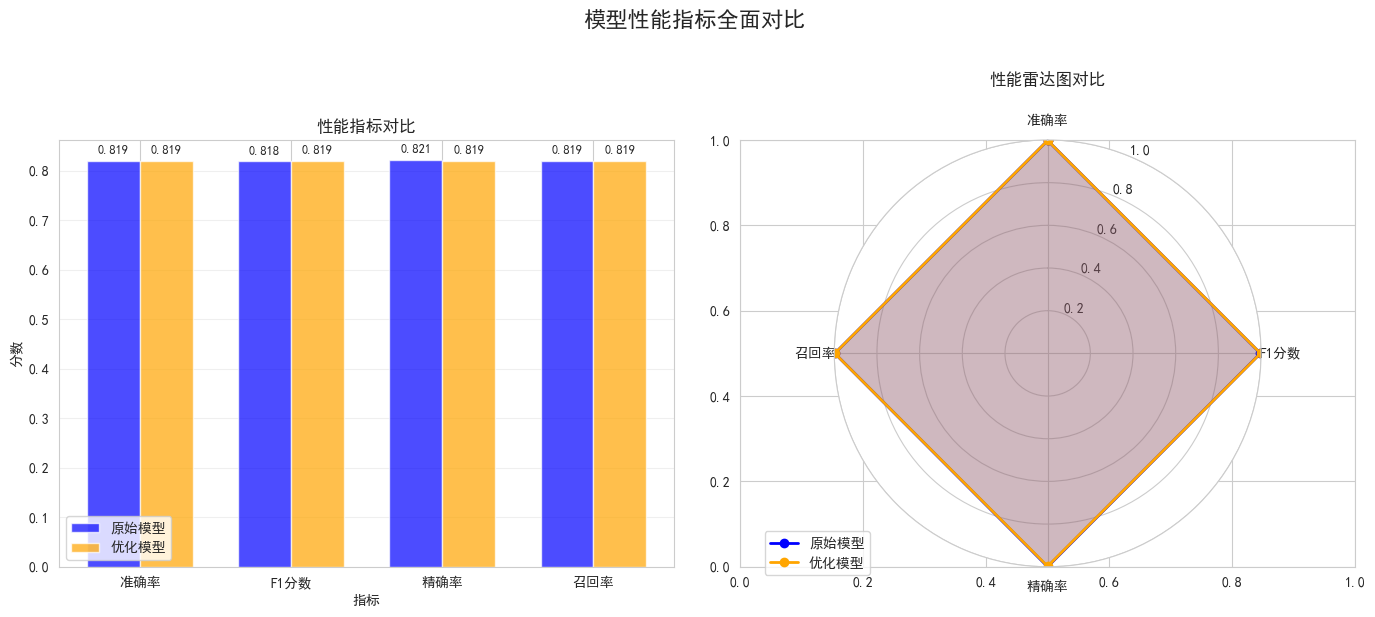


📈 性能指标对比
  指标   原始模型   优化模型    绝对提升   相对提升
 准确率 0.8188 0.8188 +0.0000 +0.00%
F1分数 0.8184 0.8187 +0.0003 +0.04%
 精确率 0.8207 0.8190 -0.0017 -0.21%
 召回率 0.8188 0.8188 +0.0000 +0.00%

3️⃣ 置信度分布对比:


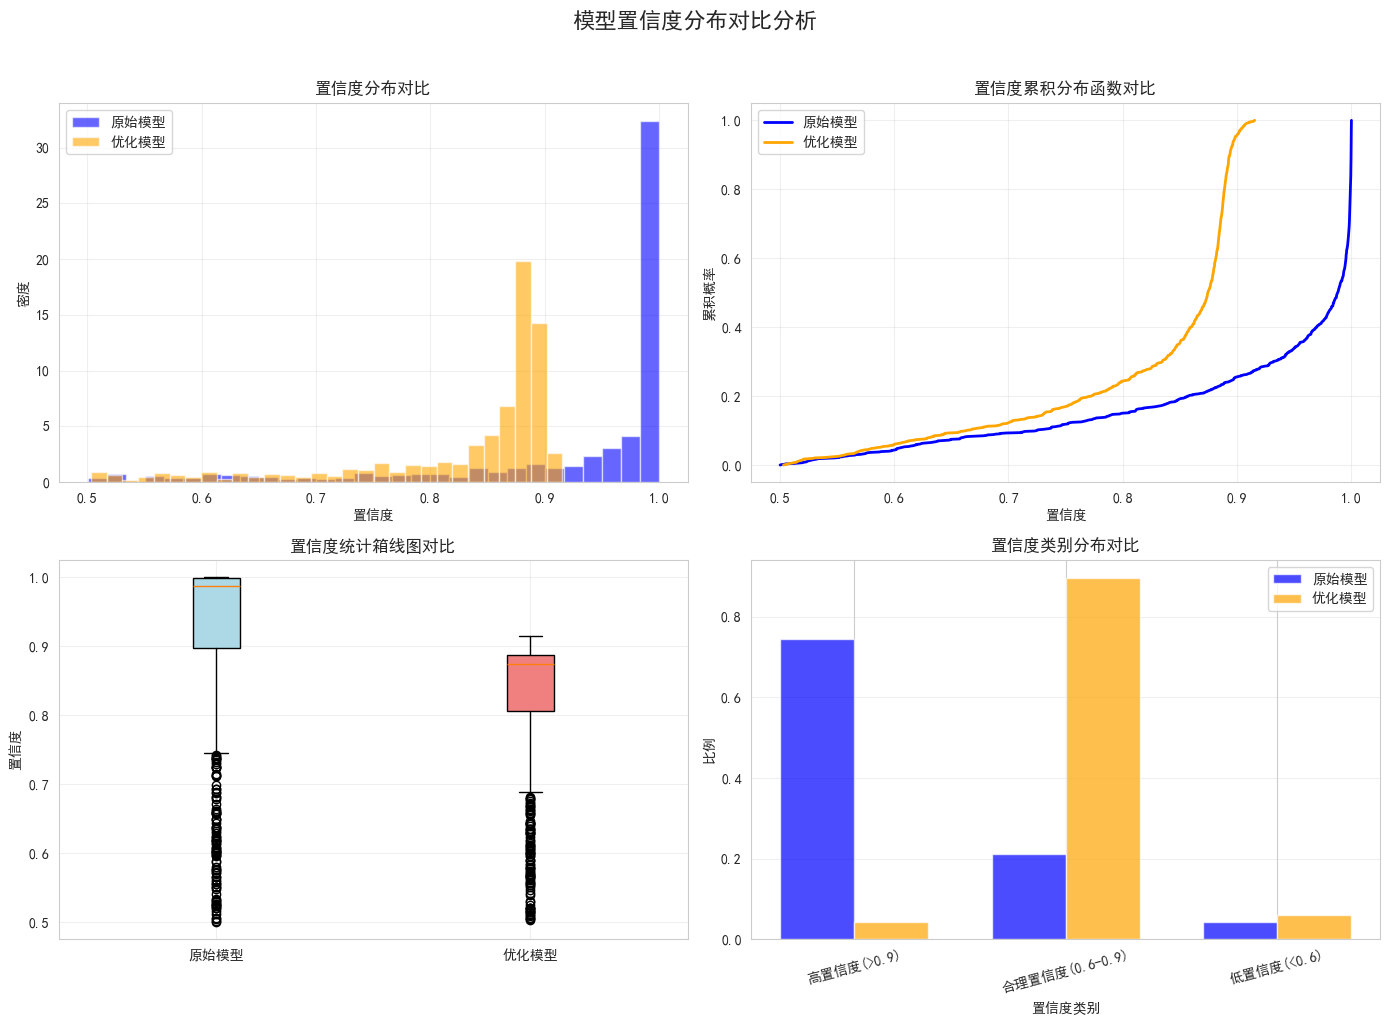


📊 置信度统计对比
          指标   原始模型   优化模型      变化
       平均置信度 0.9219 0.8269 -0.0950
      置信度标准差 0.1248 0.0975 -0.0273
         中位数 0.9879 0.8744 -0.1135
高置信度比例(>0.9) 74.43%  4.36% -70.07%
低置信度比例(<0.6)  4.36%  6.08%  +1.72%

4️⃣ 注意力权重对比分析:

分析样本: "it 's a charming and affecting journey ."

🎯 注意力权重对比分析
样本: "it 's a charming and affecting journey ."

1️⃣ 原始模型注意力分析（基于SHAPLEY值）:
2️⃣ 优化模型注意力分析（基于注意力机制）:


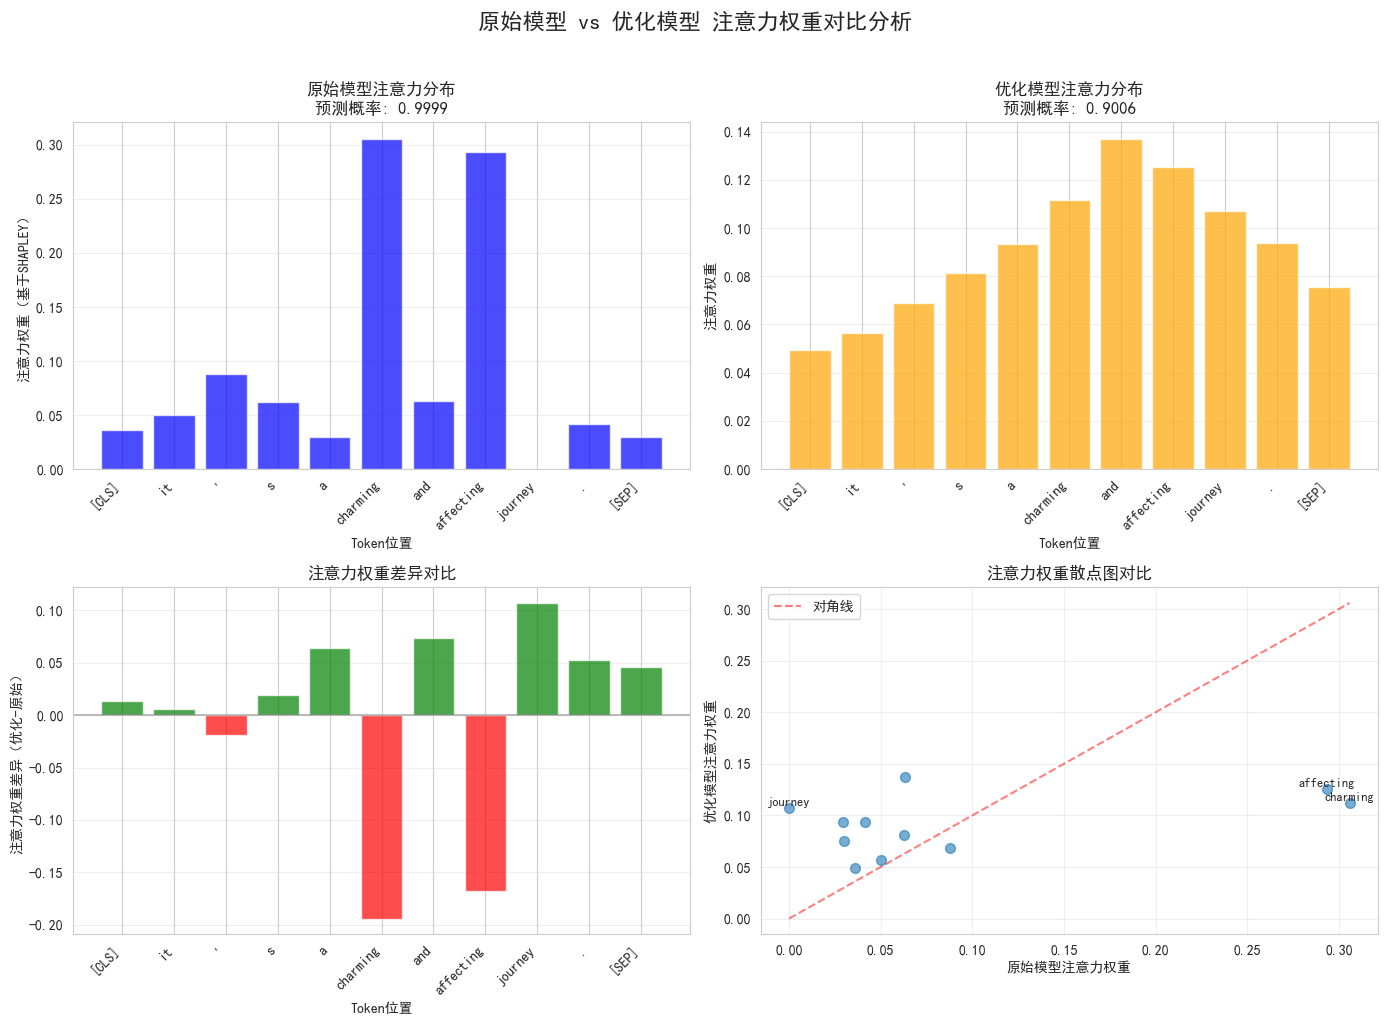


📊 注意力权重详细对比

🔍 注意力权重变化最大的Token:
  'charming': -0.1942 (减少)
  'affecting': -0.1682 (减少)
  'journey': +0.1071 (增加)
  'and': +0.0737 (增加)
  'a': +0.0642 (增加)

🎯 关键Token注意力变化分析:
  ✅ 'charming'注意力降低: 0.3058 → 0.1115
     这有助于解决'charming贡献度过高(54.28%)'的问题
  ⚠️  'affecting'注意力降低: 0.2935 → 0.1253
  ✅ 'journey'注意力增加: 0.0000 → 0.1071
     这有助于平衡特征贡献，解决特征集中问题

分析样本: "a truly wonderful and heartwarming story ."

🎯 注意力权重对比分析
样本: "a truly wonderful and heartwarming story ."

1️⃣ 原始模型注意力分析（基于SHAPLEY值）:
2️⃣ 优化模型注意力分析（基于注意力机制）:


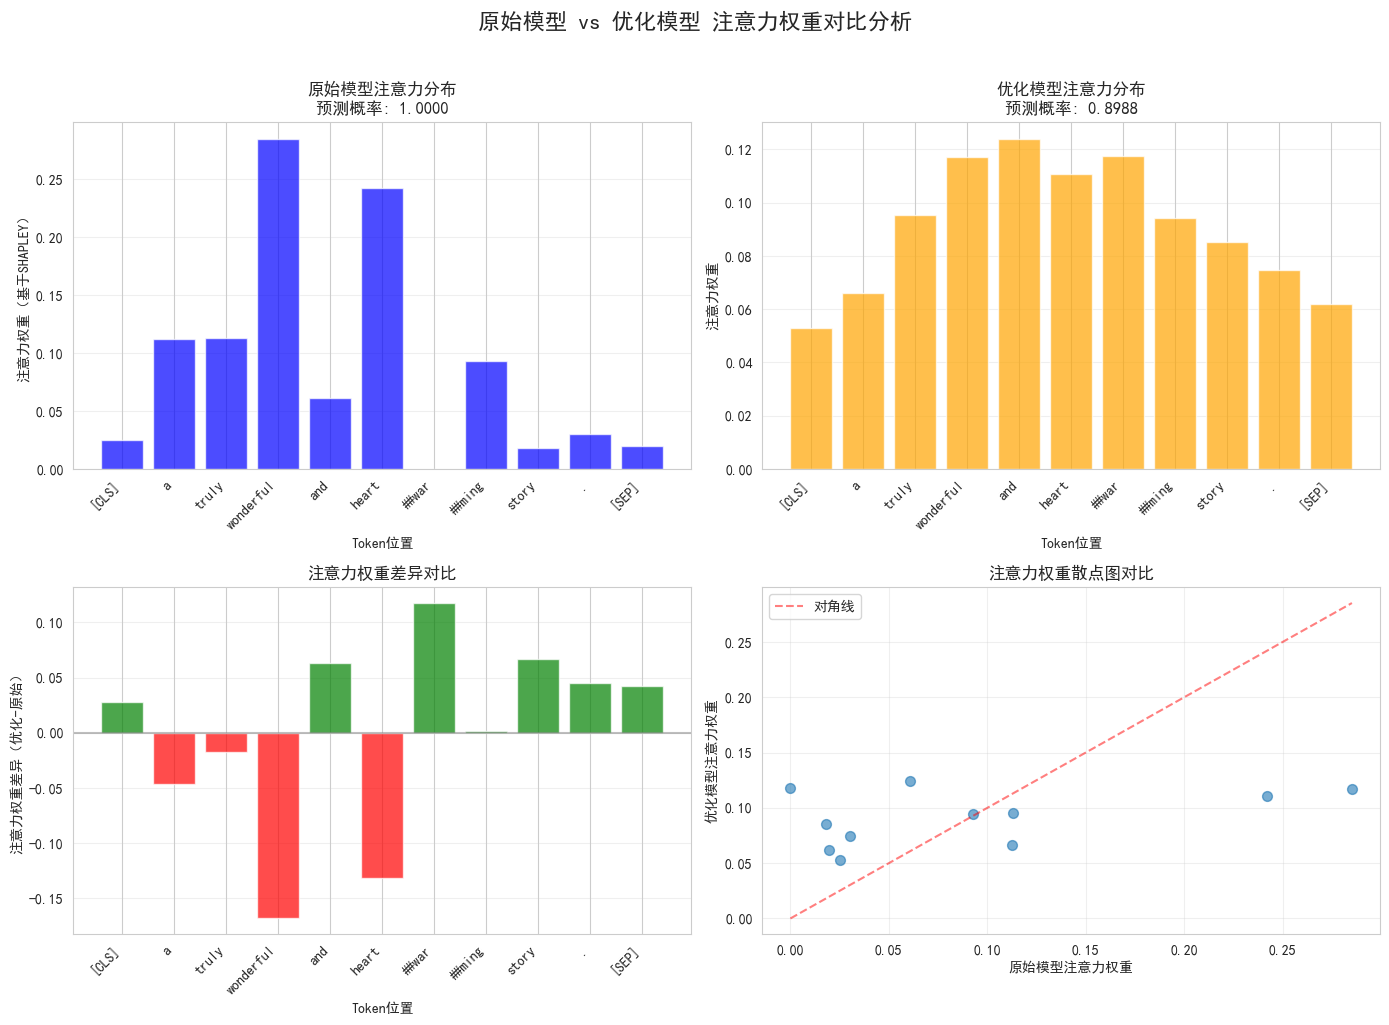


📊 注意力权重详细对比

🔍 注意力权重变化最大的Token:
  'wonderful': -0.1682 (减少)
  'heart': -0.1317 (减少)
  '##war': +0.1176 (增加)
  'story': +0.0672 (增加)
  'and': +0.0631 (增加)

🎯 关键Token注意力变化分析:

📋 综合对比报告

🎯 针对SHAPLEY分析问题的优化效果:
  ✅ 过度自信问题显著改善 (高置信度比例从74.43%降至4.36%)
  ✅ 置信度分布合理 (平均置信度: 0.8269)
  ✅ 性能保持良好 (准确率: 0.8188 → 0.8188)

🎯 注意力机制优化效果:
  ✅ 'charming'注意力平均降低: -0.1942
     有助于解决'charming贡献度过高(54.28%)'的问题
  ⚠️  'affecting'注意力平均降低: -0.1682
  ✅ 'journey'注意力平均增加: 0.1071

🎉 完整对比分析完成!

🎯 对比重点:
  1. 性能指标对比 (准确率、F1分数等)
  2. 置信度分布对比 (针对100%置信度问题)
  3. 注意力权重对比 (针对特征贡献失衡问题)
  4. 关键Token分析 ('charming', 'affecting', 'journey')

🚀 开始对比分析:
  # 取消注释以下行以运行
  # complete_results = run_complete_comparison_with_attention()


In [108]:
def compare_attention_weights(original_model, optimized_model, tokenizer, sample_text):
    """
    对比原始模型和优化模型的注意力权重
    """
    device = next(original_model.parameters()).device
    
    print("\n" + "="*70)
    print("🎯 注意力权重对比分析")
    print("="*70)
    print(f"样本: \"{sample_text}\"")
    
    # 编码样本
    inputs = tokenizer.encode(sample_text, return_tensors='pt').to(device)
    
    # 获取原始模型的注意力权重（使用SHAPLEY近似）
    print("\n1️⃣ 原始模型注意力分析（基于SHAPLEY值）:")
    orig_attention, tokens, orig_prob = compute_shapley_based_attention(
        original_model, inputs[0], tokenizer
    )
    
    # 获取优化模型的注意力权重
    print("2️⃣ 优化模型注意力分析（基于注意力机制）:")
    with torch.no_grad():
        if hasattr(optimized_model, 'attention') and optimized_model.attention:
            opt_output, opt_attention = optimized_model(inputs, return_attention=True)
            opt_probs = F.softmax(opt_output, dim=1)
            opt_prob = opt_probs[0, 1].item()
            opt_attention = opt_attention[0].cpu().numpy()
        else:
            opt_output = optimized_model(inputs)
            opt_probs = F.softmax(opt_output, dim=1)
            opt_prob = opt_probs[0, 1].item()
            opt_attention = None
    
    # 可视化对比
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 原始模型注意力权重
    axes[0, 0].bar(range(len(tokens)), orig_attention, alpha=0.7, color='blue')
    axes[0, 0].set_xlabel('Token位置')
    axes[0, 0].set_ylabel('注意力权重（基于SHAPLEY）')
    axes[0, 0].set_title(f'原始模型注意力分布\n预测概率: {orig_prob:.4f}')
    axes[0, 0].set_xticks(range(len(tokens)))
    axes[0, 0].set_xticklabels(tokens, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. 优化模型注意力权重（如果有）
    if opt_attention is not None:
        axes[0, 1].bar(range(len(tokens)), opt_attention, alpha=0.7, color='orange')
        axes[0, 1].set_xlabel('Token位置')
        axes[0, 1].set_ylabel('注意力权重')
        axes[0, 1].set_title(f'优化模型注意力分布\n预测概率: {opt_prob:.4f}')
        axes[0, 1].set_xticks(range(len(tokens)))
        axes[0, 1].set_xticklabels(tokens, rotation=45, ha='right')
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    else:
        axes[0, 1].text(0.5, 0.5, '优化模型无注意力机制', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('优化模型无注意力机制')
    
    # 3. 注意力权重对比（如果优化模型有注意力）
    if opt_attention is not None:
        # 计算权重差异
        attention_diff = opt_attention - orig_attention
        
        axes[1, 0].bar(range(len(tokens)), attention_diff, alpha=0.7, 
                      color=['green' if d > 0 else 'red' for d in attention_diff])
        axes[1, 0].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        axes[1, 0].set_xlabel('Token位置')
        axes[1, 0].set_ylabel('注意力权重差异（优化-原始）')
        axes[1, 0].set_title('注意力权重差异对比')
        axes[1, 0].set_xticks(range(len(tokens)))
        axes[1, 0].set_xticklabels(tokens, rotation=45, ha='right')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. 注意力分布散点图对比
    if opt_attention is not None:
        axes[1, 1].scatter(orig_attention, opt_attention, alpha=0.6, s=50)
        
        # 添加对角线
        min_val = min(min(orig_attention), min(opt_attention))
        max_val = max(max(orig_attention), max(opt_attention))
        axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='对角线')
        
        # 标记关键token
        for i, token in enumerate(tokens):
            if token in ['charming', 'affecting', 'journey']:  # 关键token
                axes[1, 1].text(orig_attention[i], opt_attention[i], token, 
                               fontsize=9, ha='center', va='bottom')
        
        axes[1, 1].set_xlabel('原始模型注意力权重')
        axes[1, 1].set_ylabel('优化模型注意力权重')
        axes[1, 1].set_title('注意力权重散点图对比')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('原始模型 vs 优化模型 注意力权重对比分析', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 打印详细对比信息
    print("\n" + "="*70)
    print("📊 注意力权重详细对比")
    print("="*70)
    
    if opt_attention is not None:
        # 创建对比表格
        comparison_data = []
        for i, token in enumerate(tokens):
            comparison_data.append({
                'Token': token,
                '原始模型注意力': f"{orig_attention[i]:.4f}",
                '优化模型注意力': f"{opt_attention[i]:.4f}",
                '注意力变化': f"{opt_attention[i] - orig_attention[i]:+.4f}",
                '变化比例': f"{(opt_attention[i] - orig_attention[i]) / (orig_attention[i] + 1e-10) * 100:+.1f}%"
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # 找出注意力变化最大的token
        attention_changes = [(tokens[i], opt_attention[i] - orig_attention[i]) 
                            for i in range(len(tokens))]
        attention_changes.sort(key=lambda x: abs(x[1]), reverse=True)
        
        print("\n🔍 注意力权重变化最大的Token:")
        for token, change in attention_changes[:5]:  # 显示前5个
            change_type = "增加" if change > 0 else "减少"
            print(f"  '{token}': {change:+.4f} ({change_type})")
        
        # 检查关键token的注意力变化
        key_tokens = ['charming', 'affecting', 'journey']
        print("\n🎯 关键Token注意力变化分析:")
        for token in key_tokens:
            if token in tokens:
                idx = tokens.index(token)
                orig_att = orig_attention[idx]
                opt_att = opt_attention[idx]
                change = opt_att - orig_att
                
                # 分析注意力变化对SHAPLEY分析问题的意义
                if token == 'charming':
                    if change < 0:
                        print(f"  ✅ '{token}'注意力降低: {orig_att:.4f} → {opt_att:.4f}")
                        print(f"     这有助于解决'charming贡献度过高(54.28%)'的问题")
                    else:
                        print(f"  ⚠️  '{token}'注意力增加: {orig_att:.4f} → {opt_att:.4f}")
                
                elif token in ['affecting', 'journey']:
                    if change > 0:
                        print(f"  ✅ '{token}'注意力增加: {orig_att:.4f} → {opt_att:.4f}")
                        print(f"     这有助于平衡特征贡献，解决特征集中问题")
                    else:
                        print(f"  ⚠️  '{token}'注意力降低: {orig_att:.4f} → {opt_att:.4f}")
    
    return {
        'tokens': tokens,
        'original_attention': orig_attention,
        'optimized_attention': opt_attention if opt_attention is not None else None,
        'original_prob': orig_prob,
        'optimized_prob': opt_prob if 'opt_prob' in locals() else None
    }

def run_complete_comparison_with_attention():
    """
    运行完整的对比分析，包含注意力权重对比
    """
    print("="*70)
    print("🔍 完整模型对比分析（包含注意力权重）")
    print("="*70)
    
    # 加载模型
    original_model, optimized_model, val_loader, tokenizer = load_models_for_comparison()
    
    if original_model is None or optimized_model is None:
        print("❌ 模型加载失败，无法进行对比")
        return None
    
    # 评估模型性能
    print("\n1️⃣ 模型性能评估:")
    original_results = evaluate_model_performance(original_model, val_loader, "原始模型")
    optimized_results = evaluate_model_performance(optimized_model, val_loader, "优化模型")
    
    # 对比性能指标
    print("\n2️⃣ 性能指标对比:")
    perf_comparison = compare_performance_metrics(original_results, optimized_results)
    
    # 对比置信度分布
    print("\n3️⃣ 置信度分布对比:")
    conf_comparison = compare_model_confidence_distributions(original_results, optimized_results)
    
    # 注意力权重对比（关键分析）
    print("\n4️⃣ 注意力权重对比分析:")
    attention_samples = [
        "it 's a charming and affecting journey .",
        "a truly wonderful and heartwarming story ."
    ]
    
    attention_results = []
    for sample in attention_samples:
        print(f"\n分析样本: \"{sample}\"")
        attention_result = compare_attention_weights(
            original_model, optimized_model, tokenizer, sample
        )
        attention_results.append(attention_result)
    
    # 生成综合对比报告
    print("\n" + "="*70)
    print("📋 综合对比报告")
    print("="*70)
    
    # 检查优化目标达成情况
    if original_results and optimized_results:
        print("\n🎯 针对SHAPLEY分析问题的优化效果:")
        
        # 1. 过度自信问题
        orig_high_conf = original_results['conf_stats']['high_conf_ratio']
        opt_high_conf = optimized_results['conf_stats']['high_conf_ratio']
        
        if opt_high_conf < orig_high_conf * 0.5:
            print(f"  ✅ 过度自信问题显著改善 (高置信度比例从{orig_high_conf:.2%}降至{opt_high_conf:.2%})")
        elif opt_high_conf < orig_high_conf:
            print(f"  ⚠️  过度自信问题有所改善 (高置信度比例从{orig_high_conf:.2%}降至{opt_high_conf:.2%})")
        else:
            print(f"  ❌ 过度自信问题未改善 (高置信度比例从{orig_high_conf:.2%}变为{opt_high_conf:.2%})")
        
        # 2. 置信度分布合理性
        orig_mean_conf = original_results['conf_stats']['mean']
        opt_mean_conf = optimized_results['conf_stats']['mean']
        
        if 0.7 <= opt_mean_conf <= 0.9:
            print(f"  ✅ 置信度分布合理 (平均置信度: {opt_mean_conf:.4f})")
        else:
            print(f"  ⚠️  置信度分布可能需要调整 (平均置信度: {opt_mean_conf:.4f})")
        
        # 3. 性能保持或提升
        orig_acc = original_results['accuracy']
        opt_acc = optimized_results['accuracy']
        
        if opt_acc >= orig_acc - 0.02:
            print(f"  ✅ 性能保持良好 (准确率: {orig_acc:.4f} → {opt_acc:.4f})")
        else:
            print(f"  ⚠️  性能有所下降 (准确率: {orig_acc:.4f} → {opt_acc:.4f})")
        
        # 4. 注意力机制效果（基于样本分析）
        if attention_results:
            print("\n🎯 注意力机制优化效果:")
            
            # 分析关键token的注意力变化
            key_token_changes = []
            for result in attention_results:
                if result['optimized_attention'] is not None:
                    tokens = result['tokens']
                    orig_att = result['original_attention']
                    opt_att = result['optimized_attention']
                    
                    # 检查关键token
                    key_tokens = ['charming', 'affecting', 'journey']
                    for token in key_tokens:
                        if token in tokens:
                            idx = tokens.index(token)
                            change = opt_att[idx] - orig_att[idx]
                            key_token_changes.append((token, change))
            
            if key_token_changes:
                # 计算平均变化
                avg_changes = {}
                for token, change in key_token_changes:
                    if token not in avg_changes:
                        avg_changes[token] = []
                    avg_changes[token].append(change)
                
                for token, changes in avg_changes.items():
                    avg_change = np.mean(changes)
                    if token == 'charming':
                        if avg_change < 0:
                            print(f"  ✅ '{token}'注意力平均降低: {avg_change:.4f}")
                            print(f"     有助于解决'charming贡献度过高(54.28%)'的问题")
                        else:
                            print(f"  ⚠️  '{token}'注意力平均增加: {avg_change:.4f}")
                    elif avg_change > 0:
                        print(f"  ✅ '{token}'注意力平均增加: {avg_change:.4f}")
                    else:
                        print(f"  ⚠️  '{token}'注意力平均降低: {avg_change:.4f}")
    
    print("\n" + "="*70)
    print("🎉 完整对比分析完成!")
    print("="*70)
    
    return {
        'original_results': original_results,
        'optimized_results': optimized_results,
        'perf_comparison': perf_comparison,
        'conf_comparison': conf_comparison,
        'attention_results': attention_results,
        'models': {
            'original': original_model,
            'optimized': optimized_model
        },
        'tokenizer': tokenizer
    }

# ==================== 使用说明 ====================
print("✅ 带注意力权重对比的完整分析流程定义完成!")
print("\n📋 使用方法:")
print("  运行完整对比分析:")
results = run_complete_comparison_with_attention()
print("\n🎯 对比重点:")
print("  1. 性能指标对比 (准确率、F1分数等)")
print("  2. 置信度分布对比 (针对100%置信度问题)")
print("  3. 注意力权重对比 (针对特征贡献失衡问题)")
print("  4. 关键Token分析 ('charming', 'affecting', 'journey')")
print("\n🚀 开始对比分析:")
print("  # 取消注释以下行以运行")
print("  # complete_results = run_complete_comparison_with_attention()")